In [8]:
# Run this cell if using Collab
!pip install kymatio
!pip install -U "ray[tune]"
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞—Ç–∞—Å–µ—Ç–∞

In [9]:
%%bash
git clone https://huggingface.co/datasets/mexalon/Synth_Seism/
mv -i /content/Synth_Seism/imgs/ /content/
mv -i /content/Synth_Seism/model_states/  /content/
mv -i /content/Synth_Seism/100k_train.hdf5 /content/
mv -i /content/Synth_Seism/1k_val.hdf5 /content/
rm -r /content/Synth_Seism/

Cloning into 'Synth_Seism'...
Filtering content: 100% (17/17), 3.94 GiB | 49.18 MiB/s, done.
mv: overwrite '/content/imgs'? 

In [10]:
import torch
from torch import Tensor
from torch.utils.data import DataLoader
import torch.nn as nn
from kymatio.torch import Scattering1D

import wandb

import h5py
import numpy as np
import pandas as pd
import pywt

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import random

import os
import glob

CURR_DIR = os.getcwd()
train_h5_path = f'{CURR_DIR}/100k_train.hdf5'
test_h5_path = f'{CURR_DIR}/1k_val.hdf5'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

cpu


## –ü–æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –∑–∞–¥–∞—á–∏ –¥–ª—è –≥–ª—É–±–æ–∫–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è
* –ó–∞–¥–∞—á–∞ –¥–∞–Ω–Ω–æ–π —Ä–∞–±–æ—Ç—ã ‚Äì –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –º–µ—Ç–æ–¥–∞ –∞–Ω–∞–ª–∏–∑–∞ –≤–æ–ª–Ω–æ–≤—ã—Ö —Ñ–æ—Ä–º —Å–∏–≥–Ω–∞–ª–æ–≤, –ø–æ–ª—É—á–µ–Ω–Ω—ã—Ö –≤ —Ö–æ–¥–µ –º–∏–∫—Ä–æ—Å–µ–π—Å–º–∏—á–µ—Å–∫–æ–≥–æ –º–æ–Ω–∏—Ç–æ—Ä–∏–Ω–≥–∞ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º –Ω–µ–π—Ä–æ–Ω–Ω–æ–π —Å–µ—Ç–∏ —Å —Ü–µ–ª—å—é –ª–æ–∫–∞–ª–∏–∑–∞—Ü–∏–∏ –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç –∏—Å—Ç–æ—á–Ω–∏–∫–æ–≤ —Å–µ–π—Å–º–∏—á–µ—Å–∫–∏—Ö —Å–æ–±—ã—Ç–∏–π, –∏ –∏—Ö –¥–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏–∞—Ü–∏—è. –í —Ä–∞–º–∫–∞—Ö –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –¥–∏–ø–ª–æ–º–Ω–æ–π —Ä–∞–±–æ—Ç—ã —Ä–µ—à–∞–ª–∞—Å—å –ø–æ–¥–∑–∞–¥–∞—á–∞ ‚Äì —Å–æ–∑–¥–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏ –¥–ª—è –≤—ã–¥–µ–ª–µ–Ω–∏—è –≤—Å—Ç—É–ø–ª–µ–Ω–∏–π –æ—Ç–¥–µ–ª—å–Ω—ã—Ö —Ñ–∞–∑ –Ω–∞ –∑–∞–ø–∏—Å—è—Ö –≤–æ–ª–Ω–æ–≤—ã—Ö —Ñ–æ—Ä–º –≥—Ä—É–ø–ø—ã –ø—Ä–∏—ë–º–Ω—ã—Ö —Å—Ç–∞–Ω—Ü–∏–π.
* –ú–∏–∫—Ä–æ—Å–µ–π—Å–º–∏—á–µ—Å–∫–∏–π –º–æ–Ω–∏—Ç–æ—Ä–∏–Ω–≥ —è–≤–ª—è–µ—Ç—Å—è –æ–¥–Ω–∏–º –∏–∑ —Å—É—â–µ—Å—Ç–≤—É—é—â–∏—Ö –º–µ—Ç–æ–¥–æ–≤ –∞–Ω–∞–ª–∏–∑–∞ —Å–æ—Å—Ç–æ—è–Ω–∏—è –∏—Å—Å–ª–µ–¥—É–µ–º–æ–≥–æ –≥–µ–æ—Ñ–∏–∑–∏—á–µ—Å–∫–æ–≥–æ –æ–±—ä–µ–∫—Ç–∞: –º–µ—Å—Ç–æ—Ä–æ–∂–¥–µ–Ω–∏—è –ø–æ–ª–µ–∑–Ω—ã—Ö –∏—Å–∫–æ–ø–∞–µ–º—ã—Ö, –∫—Ä—É–ø–Ω–æ–º–∞—Å—à—Ç–∞–±–Ω—ã–µ –ø—Ä–æ–º—ã—à–ª–µ–Ω–Ω—ã–µ –æ–±—ä–µ–∫—Ç—ã –∏ —Ç. –¥. –û–Ω –≤–∫–ª—é—á–∞–µ—Ç –≤ —Å–µ–±—è —Å–∏—Å—Ç–µ–º—É –¥–∞—Ç—á–∏–∫–æ–≤, —Ñ–∏–∫—Å–∏—Ä—É—é—â–∏—Ö —Å–ª–∞–±—ã–µ —Å–µ–π—Å–º–∏—á–µ—Å–∫–∏–µ –∏–ª–∏ –∞–∫—É—Å—Ç–∏—á–µ—Å–∫–∏–µ —Å–∏–≥–Ω–∞–ª—ã, —Å–∏—Å—Ç–µ–º—É —Å–±–æ—Ä–∞ –¥–∞–Ω–Ω—ã—Ö –∏ –∞–ª–≥–æ—Ä–∏—Ç–º—ã –∏—Ö –æ–±—Ä–∞–±–æ—Ç–∫–∏. –û—Å–Ω–æ–≤–Ω–æ–π –∑–∞–¥–∞—á–µ–π –º–æ–Ω–∏—Ç–æ—Ä–∏–Ω–≥–∞ —è–≤–ª—è–µ—Ç—Å—è –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫ –º–∏–∫—Ä–æ—Å–µ–π—Å–º–∏—á–µ—Å–∫–æ–≥–æ —Å–æ–±—ã—Ç–∏—è: –≤—Ä–µ–º–µ–Ω–∏ –ø–µ—Ä–≤–æ–≥–æ –≤—Å—Ç—É–ø–ª–µ–Ω–∏—è, –º–∞–≥–Ω–∏—Ç—É–¥—ã, –µ–≥–æ –º–µ—Å—Ç–æ—Ä–∞—Å–ø–æ–ª–æ–∂–µ–Ω–∏—è –≤ –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–µ.

### –°—É—â–µ—Å—Ç–≤—É—é—â–∏–µ –º–µ—Ç–æ–¥—ã –∞–Ω–∞–ª–∏–∑–∞ –≤–æ–ª–Ω–æ–≤—ã—Ö —Ñ–æ—Ä–º —Å–µ–π—Å–º–∏—á–µ—Å–∫–∏—Ö —Å–∏–≥–Ω–∞–ª–æ–≤
* –î–ª—è —Ä–µ—à–µ–Ω–∏—è –∑–∞–¥–∞—á–∏ –ª–æ–∫–∞—Ü–∏–∏ –∏—Å—Ç–æ—á–Ω–∏–∫–æ–≤ —Å–µ–π—Å–º–∏—á–µ—Å–∫–∏—Ö —Å–æ–±—ã—Ç–∏–π –≤ —Ä–∞–∑–Ω–æ–µ –≤—Ä–µ–º—è –±—ã–ª–æ —Ä–∞–∑—Ä–∞–±–æ—Ç–∞–Ω–æ –±–æ–ª—å—à–æ–µ —á–∏—Å–ª–æ –º–µ—Ç–æ–¥–æ–≤, –∫–æ—Ç–æ—Ä—ã–µ –º–æ–∂–Ω–æ –ø–æ–¥–µ–ª–∏—Ç—å –Ω–∞ –¥–≤–µ –±–æ–ª—å—à–∏–µ –≥—Ä—É–ø–ø—ã: –º–µ—Ç–æ–¥—ã –Ω–∞ –æ—Å–Ω–æ–≤–µ –≤—Ä–µ–º–µ–Ω–∏ –ø—Ä–∏—Ö–æ–¥–∞ –≤–æ–ª–Ω –∏ –º–µ—Ç–æ–¥–æ–≤ –Ω–∞ –æ—Å–Ω–æ–≤–µ –≤–æ–ª–Ω–æ–≤—ã—Ö —Ñ–æ—Ä–º. –ü—Ä–æ—Å—Ç–µ–π—à–∏–µ –º–µ—Ç–æ–¥—ã –ø–æ—è–≤–∏–ª–∏—Å—å –±–æ–ª–µ–µ —Å—Ç–∞ –ª–µ—Ç –Ω–∞–∑–∞–¥, –∏—Ö –¥–∞–ª—å–Ω–µ–π—à–µ–µ —É—Å–ª–æ–∂–Ω–µ–Ω–∏–µ –ø—Ä–æ–∏—Å—Ö–æ–¥–∏–ª–æ –æ–¥–Ω–æ–≤—Ä–µ–º–µ–Ω–Ω–æ —Å —Ä–æ—Å—Ç–æ–º –≤—ã—á–∏—Å–ª–∏—Ç–µ–ª—å–Ω—ã—Ö –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç–µ–π –≠–í–ú. –ö –ø–µ—Ä–≤–æ–π –≥—Ä—É–ø–ø–µ –º–µ—Ç–æ–¥–æ–≤ –º–æ–∂–Ω–æ –æ—Ç–Ω–µ—Å—Ç–∏ –º–µ—Ç–æ–¥ —Ç—Ä–∏–∞–Ω–≥—É–ª—è—Ü–∏–∏, –º–µ—Ç–æ–¥ –ì–µ–π–≥–µ—Ä–∞ –∏ –º–µ—Ç–æ–¥ Grid Search [Karas√∂zen, Karas√∂zen, 2020; Milne, 2019]. –ö–æ –≤—Ç–æ—Ä–æ–π ‚Äì –º–µ—Ç–æ–¥ –Ω–∞–ª–æ–∂–µ–Ω–∏—è —á–∞—Å—Ç–∏—á–Ω–æ–≥–æ —Å–∏–≥–Ω–∞–ª–∞, –º–µ—Ç–æ–¥ –Ω–∞–ª–æ–∂–µ–Ω–∏—è –æ–±—Ä–∞—â–µ–Ω–Ω–æ–≥–æ —Å–∏–≥–Ω–∞–ª–∞ (TRI), –º–µ—Ç–æ–¥ —Ç–æ–º–æ–≥—Ä–∞—Ñ–∏–∏ –≤–æ–ª–Ω–æ–≤–æ–≥–æ —Ñ—Ä–æ–Ω—Ç–∞ (WT), –º–µ—Ç–æ–¥ –ø–æ–ª–Ω–æ–π –∏–Ω–≤–µ—Ä—Å–∏–∏ –≤–æ–ª–Ω–æ–≤–æ–π —Ñ–æ—Ä–º—ã (FWI) [Li –∏ –¥—Ä., 2020]. –û–±—â–∏–º –∏—Ö –Ω–µ–¥–æ—Å—Ç–∞—Ç–∫–æ–º –≤—Å–µ—Ö —ç—Ç–∏—Ö –º–µ—Ç–æ–¥–æ–≤ —è–≤–ª—è–µ—Ç—Å—è —Å—É—â–µ—Å—Ç–≤–µ–Ω–Ω–∞—è –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç—å –æ—Ç —Å–∫–æ—Ä–æ—Å—Ç–Ω–æ–π –º–æ–¥–µ–ª–∏ —Å—Ä–µ–¥—ã.
* –ù–µ–π—Ä–æ–Ω–Ω—ã–µ —Å–µ—Ç–∏ –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Å–µ–π—Å–º–∏—á–µ—Å–∫–∏—Ö —Å–∏–≥–Ω–∞–ª–æ–≤ –¥–µ–ª—è—Ç—Å—è –Ω–∞ –æ—Å–Ω–æ–≤–µ –ø–æ–¥—Ö–æ–¥–∞ –∫ –≤—ã–¥–µ–ª–µ–Ω–∏—é –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –ø–æ—Å–ª–µ–¥—É—é—â–µ–≥–æ –∞–Ω–∞–ª–∏–∑–∞ –≤ –º–æ–¥–µ–ª–∏. –ö–∞–∫ –ø—Ä–∞–≤–∏–ª–æ –¥–ª—è —ç—Ç–æ–≥–æ –∏—Å–ø–æ–ª—å–∑—É—é—Ç—Å—è —Ä–∞–∑–ª–∏—á–Ω—ã–µ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏—á–µ—Å–∫–∏–µ —Ñ—É–Ω–∫—Ü–∏–∏ –≤—Ä–µ–º–µ–Ω–Ω–æ–≥–æ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏—è —Å–∏–≥–Ω–∞–ª–∞ [Guo –∏ –¥—Ä., 2021],  –ª–∏–±–æ –µ–≥–æ —á–∞—Å—Ç–æ—Ç–Ω–æ-–≤—Ä–µ–º–µ–Ω–Ω—ã–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏—è.  –î–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —á–∞—Å—Ç–æ—Ç–Ω–æ-–≤—Ä–µ–º–µ–Ω–Ω—ã—Ö –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏–π —Å–∏–≥–Ω–∞–ª–æ–≤ –Ω–∞–∏–±–æ–ª–µ–µ —É—Å–ø–µ—à–Ω–æ –∏—Å–ø–æ–ª—å–∑—É—é—Ç—Å—è —Å–≤–µ—Ä–æ—á–Ω—ã–µ –Ω–µ–π—Ä–æ–Ω–Ω—ã–µ —Å–µ—Ç–µ [Zhu –∏ –¥—Ä., 2019], –∞ —Ç–∞–∫–∂–µ –ø—Ä–∏–º–µ–Ω—è–µ—Ç—Å—è transfer learning, –ø—Ä–∏ –∫–æ—Ç–æ—Ä–æ–º –ø–µ—Ä–µ–æ–±—É—á–∞—é—Ç—Å—è —Å—É—â–µ—Å—Ç–≤—É—é—â–∏–µ –º–æ–¥–µ–ª–∏ –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π [Zhu, Beroza, 2019].  –ü–æ –º–µ—Ä–µ —Ä–∞–∑–≤–∏—Ç–∏—è —Ä–µ–∫—É—Ä—Ä–µ–Ω—Ç–Ω—ã—Ö –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä, –æ–Ω–∏ —Ç–∞–∫–∂–µ —Å—Ç–∞–ª–∏ –∞–∫—Ç–∏–≤–Ω–æ –ø—Ä–∏–º–µ–Ω—è—Ç—å—Å—è –¥–ª—è –æ–±—Ä–∞–±–æ—Ç–∫–∏ —Å–µ–π—Å–º–∏—á–µ—Å–∫–∏—Ö —Å–∏–≥–Ω–∞–ª–æ–≤. –í –Ω–∞—Å—Ç–æ—è—â–µ–µ –≤—Ä–µ–º—è –Ω–∞–∏–±–æ–ª–µ–µ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ –∏—Å–ø–æ–ª—å–∑—É—é—Ç—Å—è —Å–µ—Ç–∏ –Ω–∞ –æ—Å–Ω–æ–≤–µ —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–µ—Ä–æ–≤ [Stepnov, Chernykh, Konovalov, 2021]. –¢–∞–∫–∂–µ –≤—Å—Ç—Ä–µ—á–∞—é—Ç—Å—è –∏ —Ä–∞–∑–ª–∏—á–Ω—ã–µ —Å–æ—á–µ—Ç–∞–Ω–∏—è –ø–µ—Ä–µ—á–∏—Å–ª–µ–Ω–Ω—ã—Ö –º–µ—Ç–æ–¥–æ–≤ [Mousavi –∏ –¥—Ä., 2020]. –í —Ü–µ–ª–æ–º, –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è –Ω–µ–π—Ä–æ–Ω–Ω—ã—Ö —Å–µ—Ç–µ–π –¥–ª—è –∑–∞–¥–∞—á –æ–±—Ä–∞–±–æ—Ç–∫–∏ —Å–µ–π—Å–º–∏—á–µ—Å–∫–∏—Ö —Å–∏–≥–Ω–∞–ª–æ–≤ —Ä–∞–∑–≤–∏–≤–∞–µ—Ç—Å—è –≤ –æ–±—â–µ–º —Ä—É—Å–ª–µ –∞–¥–∞–ø—Ç–∞—Ü–∏–∏ –∫ –¥–∞–Ω–Ω–æ–π –∑–∞–¥–∞—á–µ –Ω–æ–≤—ã—Ö –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤ –Ω–µ–π—Ä–æ–Ω–Ω—ã—Ö —Å–µ—Ç–µ–π –ø–æ –º–µ—Ä–µ –∏—Ö –ø–æ—è–≤–ª–µ–Ω–∏—è –≤ –≤–∏–¥–µ –æ–±—â–µ–¥–æ—Å—Ç—É–ø–Ω—ã—Ö –ø—Ä–æ–≥—Ä–∞–º–º–Ω—ã—Ö –ø—Ä–æ–¥—É–∫—Ç–æ–≤.
* –ó–∞–¥–∞—á–∞ –ª–æ–∫–∞—Ü–∏–∏ –∏—Å—Ç–æ—á–Ω–∏–∫–æ–≤ –º–∏–∫—Ä–æ—Å–µ–π—Å–º–∏—á–µ—Å–∫–∏—Ö —Å–æ–±—ã—Ç–∏–π –¥–æ —Å–∏—Ö –ø–æ—Ä –Ω–µ –∏–º–µ–µ—Ç —Ö–æ—Ä–æ—à–µ–≥–æ —Ä–µ—à–µ–Ω–∏—è.  –ú–∏–∫—Ä–æ—Å–µ–π—Å–º–∏—á–µ—Å–∫–∏–π –º–æ–Ω–∏—Ç–æ—Ä–∏–Ω–≥ –∫–∞–∫ –ø—Ä–∞–≤–∏–ª–æ –ø—Ä–æ–≤–æ–¥–∏—Ç—Å—è —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º –±–æ–ª—å—à–æ–π —Å–µ—Ç–∏ –ø—Ä–∏–Ω–∏–º–∞—é—â–∏—Ö —Å—Ç–∞–Ω—Ü–∏–π (—Å–æ—Ç–Ω–∏ –∏ –∏–Ω–æ–≥–¥–∞ –¥–∞–∂–µ —Ç—ã—Å—è—á–∏ –ø—Ä–∏–±–æ—Ä–æ–≤). –ü—Ä–∏ —ç—Ç–æ–º –∫–∞—á–µ—Å—Ç–≤–æ –∑–∞–ø–∏—Å–∏ –∫–∞–∂–¥–æ–π –æ—Ç–¥–µ–ª—å–Ω–æ–π —Å—Ç–∞–Ω—Ü–∏–∏ –±—ã–≤–∞–µ—Ç –æ—á–µ–Ω—å –ø–ª–æ—Ö–æ–µ, —á—Ç–æ –¥–µ–ª–∞–µ—Ç –Ω–µ–≤–æ–∑–º–æ–∂–Ω—ã–º –ø—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –∫–ª–∞—Å—Å–∏—á–µ—Å–∫–∏—Ö –º–µ—Ç–æ–¥–æ–≤. –ú–æ–¥–µ–ª—å –¥–ª—è —Ä–∞–±–æ—Ç—ã —Å —Ç–∞–∫–∏–º–∏ –¥–∞–Ω–Ω—ã–º–∏ –¥–æ–ª–∂–Ω–∞ —Å—Ç—Ä–æ–∏—Ç—å—Å—è –Ω–∞ –æ—Å–Ω–æ–≤–µ –ø–∞—Ä–∞–ª–ª–µ–ª—å–Ω–æ–≥–æ –∞–Ω–∞–ª–∏–∑–∞ –≤—Å–µ–≥–æ –º–∞—Å—Å–∏–≤–∞ –∑–∞–ø–∏—Å–µ–π. –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∞–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º—ã—Ö –∑–∞–ø–∏—Å–µ–π –ø—Ä–∏ —ç—Ç–æ–º –º–æ–∂–µ—Ç –ø—Ä–æ–∏–∑–≤–æ–ª—å–Ω–æ –º–µ–Ω—è—Ç—å—Å—è.

1. And√©n J., Mallat S. Deep scattering spectrum // IEEE Transactions on Signal Processing. 2014. –¢. 62. ‚Ññ 16. –°. 4114‚Äì4128.
2. Andreux M. –∏ –¥—Ä. Kymatio: Scattering transforms in python // Journal of Machine Learning Research. 2020. –¢. 21. –°. 1‚Äì6.
3. Guo C. –∏ –¥—Ä. AEnet: Automatic Picking of P-Wave First Arrivals Using Deep Learning // IEEE Transactions on Geoscience and Remote Sensing. 2021. –¢. 59. ‚Ññ 6. –°. 5293‚Äì5303.
4. Heimann S. –∏ –¥—Ä. Pyrocko‚ÄØ: A Versatile Software Framework for Seismology // 2018. –¢. 20. –°. 17314.
5. Karas√∂zen E., Karas√∂zen B. Earthquake location methods // GEM. 2020. –¢. 11. ‚Ññ 1.
6. Li L. –∏ –¥—Ä. Recent advances and challenges of waveform‚Äêbased seismic location methods at multiple scales // Reviews of Geophysics. 2020. –¢. 58. ‚Ññ 1. –°. 1‚Äì47.
7. M√°lek J., Hor√°lek J., Jansk√Ω J. One-Dimensional qP-Wave Velocity Model of the Upper Crust for the West Bohemia/Vogtland Earthquake Swarm Region // Studia Geophysica et Geodaetica 2005 49:4. 2005. –¢. 49. ‚Ññ 4. –°. 501‚Äì524.
8. Milne J. Earthquakes and other earth movements // Earthquakes and other Earth Movements. 2019. –¢. LVI. –°. 1‚Äì366.
9. Mousavi S. M. –∏ –¥—Ä. Earthquake transformer‚Äîan attentive deep-learning model for simultaneous earthquake detection and phase picking // Nat Commun. 2020. –¢. 11. ‚Ññ 1.
10. Stepnov A., Chernykh V., Konovalov A. The seismo-performer: A novel machine learning approach for general and efficient seismic phase recognition from local earthquakes in real time // Sensors. 2021. –¢. 21. ‚Ññ 18.
11. Vaswani A. –∏ –¥—Ä. Attention is all you need // Adv Neural Inf Process Syst. 2017. –¢. 2017-Decem. ‚Ññ Nips. –°. 5999‚Äì6009.
12. Zhu L. –∏ –¥—Ä. Deep learning for seismic phase detection and picking in the aftershock zone of 2008 Mw7.9 Wenchuan Earthquake // Physics of the Earth and Planetary Interiors. 2019. –¢. 293.
13. Zhu W., Beroza G. C. PhaseNet: A deep-neural-network-based seismic arrival-time picking method // Geophys J Int. 2019. –¢. 216. ‚Ññ 1. –°. 261‚Äì273.


## –î–∞–Ω–Ω—ã–µ –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏
* –û—Å–Ω–æ–≤–Ω—ã–º –æ—Ç–ª–∏—á–∏–µ–º –ø—Ä–µ–¥–ª–∞–≥–∞–µ–º–æ–≥–æ –ø–æ–¥—Ö–æ–¥–∞ –æ—Ç –±–æ–ª—å—à–∏–Ω—Å—Ç–≤–∞ —Ä–∞–Ω–µ–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–Ω—ã—Ö —è–≤–ª—è–µ—Ç—Å—è –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ —Å–∏–Ω—Ç–µ—Ç–∏—á–µ—Å–∫–∏—Ö –≤–æ–ª–Ω–æ–≤—ã—Ö —Ñ–æ—Ä–º –¥–ª—è —Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏—è –æ–±—É—á–∞—é—â–µ–π –≤—ã–±–æ—Ä–∫–∏. –ü—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–æ —Ç–∞–∫–æ–≥–æ –ø–æ–¥—Ö–æ–¥–∞ —Å–æ—Å—Ç–æ–∏—Ç –≤ —Ç–æ–º, —á—Ç–æ –¥–ª—è —Å–∏–Ω—Ç–µ—Ç–∏—á–µ—Å–∫–∏—Ö –¥–∞–Ω–Ω—ã—Ö –∑–∞—Ä–∞–Ω–µ–µ –∏–∑–≤–µ—Å—Ç–Ω—ã –≤—Å–µ –Ω–µ–æ–±—Ö–æ–¥–∏–º—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –∫–∞–∂–¥–æ–≥–æ —Å–µ–π—Å–º–∏—á–µ—Å–∫–æ–≥–æ —Å–æ–±—ã—Ç–∏—è (–≤—Ä–µ–º—è –≤—Å—Ç—É–ø–ª–µ–Ω–∏—è, –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã –∏—Å—Ç–æ—á–Ω–∏–∫–∞, –º–∞–≥–Ω–∏—Ç—É–¥–∞, –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –º–µ—Ö–∞–Ω–∏–∑–º–∞ –∏—Å—Ç–æ—á–Ω–∏–∫–∞, —Å–∫–æ—Ä–æ—Å—Ç–Ω–∞—è –º–æ–¥–µ–ª—å —Å—Ä–µ–¥—ã). –≠—Ç–æ –¥–∞–µ—Ç –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç—å —Å–æ–∑–¥–∞–≤–∞—Ç—å –∏ –æ–±—É—á–∞—Ç—å –º–æ–¥–µ–ª–∏ –Ω–∞ –¥–∞–Ω–Ω—ã—Ö, —Å—Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö —Å —É—á—ë—Ç–æ–º –æ—Å–æ–±–µ–Ω–Ω–æ—Å—Ç–µ–π, —Ö–∞—Ä–∞–∫—Ç–µ—Ä–Ω—ã—Ö –¥–ª—è –∑–∞–¥–∞–Ω–Ω–æ–≥–æ —Ä–∞–π–æ–Ω–∞ –ø—Ä–æ–≤–µ–¥–µ–Ω–∏—è –º–æ–Ω–∏—Ç–æ—Ä–∏–Ω–≥–∞, –ø–æ–ª—É—á–∞–µ–º—ã–µ –º–æ–¥–µ–ª–∏ –ø—Ä–∏ —ç—Ç–æ–º –º–æ–≥—É—Ç –æ–±–ª–∞–¥–∞—Ç—å –±–æ–ª—å—à–µ–π –æ–±–æ–±—â–∞—é—â–µ–π —Å–ø–æ—Å–æ–±–Ω–æ—Å—Ç—å—é, —á–µ–º –æ–±—É—á–µ–Ω–Ω—ã–µ –Ω–∞ —Ä–µ–∞–ª—å–Ω—ã—Ö –≤–æ–ª–Ω–æ–≤—ã—Ö —Ñ–æ—Ä–º–∞—Ö. –ö—Ä–æ–º–µ —Ç–æ–≥–æ, —Ç–∞–∫–æ–π –ø–æ–¥—Ö–æ–¥, –≤ –æ—Ç–ª–∏—á–∏–µ –æ—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è –±–∞–Ω–∫–æ–≤ —Ä–µ–∞–ª—å–Ω—ã—Ö –≤–æ–ª–Ω–æ–≤—ã—Ö —Ñ–æ—Ä–º –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏, –∏—Å–∫–ª—é—á–∞–µ—Ç –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç—å –∏—Å–∫–∞–∂–µ–Ω–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤, —Å–≤—è–∑–∞–Ω–Ω—É—é —Å –ø—Ä–∏–º–µ–Ω–µ–Ω–∏–µ–º —Ä—É—á–Ω–æ–π —Ä–∞–∑–º–µ—Ç–∫–∏ –¥–∞–Ω–Ω—ã—Ö. –ì–ª–∞–≤–Ω—ã–º –Ω–µ–¥–æ—Å—Ç–∞—Ç–∫–æ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è —Å–∏–Ω—Ç–µ—Ç–∏—á–µ—Å–∫–∏—Ö –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–µ–π —Å–≤—è–∑–∞–Ω–∞ —Å –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ—Å—Ç—å—é –∞–¥–∞–ø—Ç–∞—Ü–∏–∏ –ø–æ–ª—É—á–∞–µ–º—ã—Ö –º–æ–¥–µ–ª–µ–π –ø–æ–¥ —Ä–µ–∞–ª—å–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ.
–°–∏–Ω—Ç–µ—Ç–∏—á–µ—Å–∫–∏–µ –≤–æ–ª–Ω–æ–≤—ã–µ —Ñ–æ—Ä–º—ã, –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–Ω—ã–µ –≤ –¥–∞–Ω–Ω–æ–π —Ä–∞–±–æ—Ç–µ, –±—ã–ª–∏ —Å–æ–∑–¥–∞–Ω—ã –ø—Ä–∏ –ø–æ–º–æ—â–∏ Pyrocko ‚Äì –Ω–∞–±–æ—Ä–∞ –±–∏–±–ª–∏–æ—Ç–µ–∫ –¥–ª—è —Å–µ–π—Å–º–æ–ª–æ–≥–∏—á–µ—Å–∫–æ–≥–æ –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏—è —Å –æ—Ç–∫—Ä—ã—Ç—ã–º –∏—Å—Ö–æ–¥–Ω—ã–º –∫–æ–¥–æ–º [Heimann –∏ –¥—Ä., 2018].  –†–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω–∏–µ —Å–µ–π—Å–º–∏—á–µ—Å–∫–∏—Ö –≤–æ–ª–Ω –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–ª–æ—Å—å –¥–ª—è —É–ø—Ä—É–≥–æ-–≤—è–∑–∫–æ–π —Å–ª–æ–∏—Å—Ç–æ–π —Å—Ä–µ–¥—ã. –°–∫–æ—Ä–æ—Å—Ç–Ω–∞—è –º–æ–¥–µ–ª—å —Å—Ä–µ–¥—ã –±—ã–ª–∞ –≤–∑—è—Ç–∞ –∏–∑ —Ä–∞–±–æ—Ç—ã [M√°lek, Hor√°lek, Jansk√Ω, 2005]. –í—ã–±–æ—Ä –æ–ø—Ä–µ–¥–µ–ª—è–ª—Å—è –Ω–∞–ª–∏—á–∏–µ–º –≤ —Å–≤–æ–±–æ–¥–Ω–æ–º –¥–æ—Å—Ç—É–ø–µ –ø—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω–æ —Ä–∞—Å—Å—á–∏—Ç–∞–Ω–Ω–æ–≥–æ –±–∞–Ω–∫–∞ —Ñ—É–Ω–∫—Ü–∏–π –ì—Ä–∏–Ω–∞, –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ–≥–æ –¥–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è –≤–æ–ª–Ω–æ–≤—ã—Ö —Ñ–æ—Ä–º. –ò—Å—Ç–æ—á–Ω–∏–∫–∏ —Å–µ–π—Å–º–∏—á–µ—Å–∫–∏—Ö —Å–∏–≥–Ω–∞–ª–æ–≤ –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–ª–∏—Å—å –¥–≤–æ–π–Ω–æ–π –ø–∞—Ä–æ–π —Å–∏–ª —Å–æ —Å–ª—É—á–∞–π–Ω—ã–º —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ–º –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏–π —Å–º–µ—â–µ–Ω–∏—è (strike, deep, rake) –∏ –º–∞–≥–Ω–∏—Ç—É–¥–∞–º–∏, —Ä–∞–≤–Ω–æ–º–µ—Ä–Ω–æ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª—ë–Ω–Ω—ã–º–∏ –≤ –∑–∞–¥–∞–Ω–Ω—ã—Ö –≥—Ä–∞–Ω–∏—Ü–∞—Ö (0‚Äì2). –≠–ø–∏—Ü–µ–Ω—Ç—Ä—ã –∏ –≥–ª—É–±–∏–Ω—ã –∏—Å—Ç–æ—á–Ω–∏–∫–æ–≤ –∑–∞–¥–∞–≤–∞–ª–∏—Å—å —Å–ª—É—á–∞–π–Ω—ã–º –æ–±—Ä–∞–∑–æ–º –≤–Ω—É—Ç—Ä–∏ –æ–±–ª–∞—Å—Ç–∏ —Å —Ä–∞–¥–∏—É—Å–æ–º 1.5 –∫–º –∏ –≥–ª—É–±–∏–Ω–æ–π 1000 –º–µ—Ç—Ä–æ–≤. –í–æ–ª–Ω–æ–≤—ã–µ —Ñ–æ—Ä–º—ã (—Å–º–µ—â–µ–Ω–∏–µ) –±—ã–ª–∏ –ø–æ–ª—É—á–µ–Ω—ã –¥–ª—è –ø—è—Ç–∏ —Å—Ç–∞–Ω—Ü–∏–π (—á–µ—Ç—ã—Ä–µ —Å–∏–º–º–µ—Ç—Ä–∏—á–Ω–æ —Ä–∞—Å–ø–æ–ª–æ–∂–µ–Ω—ã –Ω–∞ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–∏ 500 –º–µ—Ç—Ä–æ–≤ –æ—Ç –Ω–∞—á–∞–ª–∞ –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç, –∏ –æ–¥–Ω–∞ –≤ —Ü–µ–Ω—Ç—Ä–µ ) –¥–ª—è —Ç—Ä—ë—Ö –∫–∞–Ω–∞–ª–æ–≤ (–¥–≤–∞ –≥–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª—å–Ω—ã—Ö N, E –∏ –≤–µ—Ä—Ç–∏–∫–∞–ª—å–Ω—ã–π Z) —Å —á–∞—Å—Ç–æ—Ç–æ–π –¥–∏—Å–∫—Ä–µ—Ç–∏–∑–∞—Ü–∏–∏ 100 –ì—Ü, –ø—Ä–æ—Ç—è–∂—ë–Ω–Ω–æ—Å—Ç—å –∫–∞–∂–¥–æ–π  –∑–∞–ø–∏—Å–∏ ‚Äì 4 —Å–µ–∫—É–Ω–¥—ã. –î–ª—è –∫–∞–∂–¥–æ–π –≤–æ–ª–Ω–æ–≤–æ–π —Ñ–æ—Ä–º—ã –±—ã–ª–∏ –ø–æ–ª—É—á–µ–Ω—ã –∞–ø—Ä–∏–æ—Ä–Ω—ã–µ –º–æ–º–µ–Ω—Ç—ã –ø—Ä–∏—Ö–æ–¥–∞ p –∏ s –≤–æ–ª–Ω—ã. –í —Ä–µ–∑—É–ª—å—Ç–∞—Ç–µ –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏—è –±—ã–ª–∏ —Å—Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω—ã –æ–±—É—á–∞—é—â–∞—è –∏ —Ç–µ—Å—Ç–æ–≤–∞—è –≤—ã–±–æ—Ä–∫–∏ –∏–∑ 106 –∏ 103 —Å–æ–±—ã—Ç–∏–π —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω–æ (15 –≤–æ–ª–Ω–æ–≤—ã—Ö —Ñ–æ—Ä–º –≤ –∫–∞–∂–¥–æ–º). –°—Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ —Ö—Ä–∞–Ω–∏–ª–∏—Å—å –≤ hdf5 —Ñ–æ—Ä–º–∞—Ç–µ.

![microseismic modeling sketch](./imgs/microseism_cube.drawio.png "microseismic modeling sketch")

## –ü—Ä–∏–º–µ—Ä—ã –∏–∑–≤–ª–µ—á–µ–Ω–∏—è –¥–∞–Ω–Ω—ã—Ö –∏–∑ –¥–∞—Ç–∞—Å–µ—Ç–∞

<KeysViewHDF5 ['events', 'sta0', 'sta1', 'sta2', 'sta3', 'sta4', 'stations_info']>
<KeysViewHDF5 ['arrivals', 'traces']>
<KeysViewHDF5 ['E', 'N', 'Z']>
0.8301578
[0.8301578  0.95753574 0.54443765 ... 0.8761627  0.60287815 1.0733824 ]


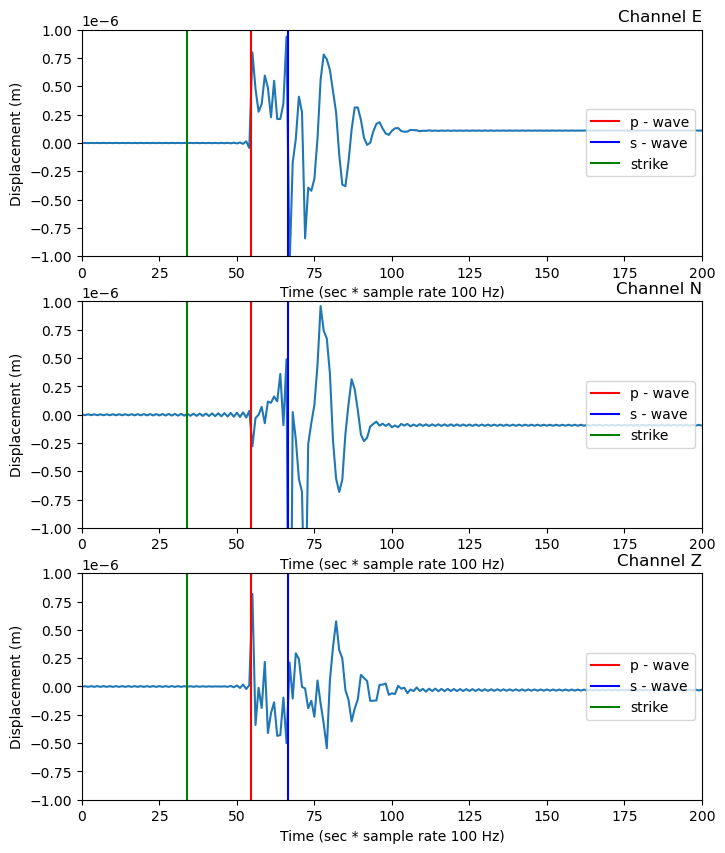

In [ ]:
h5_path = '100k_train.hdf5'

with h5py.File(h5_path, 'r') as f:
    '''get root'''
    pp = f.keys()
    print(pp)

with h5py.File(h5_path, 'r') as f:
    '''get list of station 1 (sta1) items'''
    pp = f["sta1"].keys()
    print(pp)

with h5py.File(h5_path, 'r') as f:
    '''get list of traces on sta1'''
    pp = f["sta1/traces"].keys()
    print(pp)

with h5py.File(h5_path, 'r') as f:
    '''get sta1 Z channel first trace'''
    pp = f["sta1/traces/Z"][0]
    # print(pp)

with h5py.File(h5_path, 'r') as f:
    '''get its p arrival'''
    pp = f["sta1/arrivals/p"][0]
    print(pp)

with h5py.File(h5_path, 'r') as f:
    '''get list of p arrivals on sta1'''
    pp = f["sta1/arrivals/p"][:]
    print(pp)

'''how to get station_info DataFrame'''
si = pd.read_hdf(h5_path, '/stations_info')
si.head()

'''how to get events list'''
arr = pd.read_hdf(h5_path, '/events')
arr.head()

'''some using way'''
sample_rate = si['smpl_rate_hz'][0]

trace_no = 2 # event
sta = 1 # sta num
chnlz = 'ENZ' # channel codes

fig, ax = plt.subplots(3,1, figsize=(8,10))
with h5py.File(h5_path, 'r') as f:
    for ii, ch in enumerate(chnlz):
        ax[ii].set_xlim(0,200)
        ax[ii].set_ylim(-1e-6,1e-6)
        ax[ii].plot(f[f"sta{sta}/traces/{ch}"][trace_no])
        ax[ii].axvline(x=f[f"sta{sta}/arrivals/p"][trace_no]*sample_rate, color='r', label = 'p - wave') # p-wave arrival
        ax[ii].axvline(x=f[f"sta{sta}/arrivals/s"][trace_no]*sample_rate, color='b', label = 's - wave') # s-wave arrival
        ax[ii].axvline(x=f[f"sta{sta}/arrivals/strike"][trace_no]*sample_rate, color='g', label = 'strike') # strike moment
        ax[ii].legend(loc='right')
        ax[ii].set_title(f'Channel {ch}', loc='right')
        ax[ii].set_xlabel(f'Time (sec * sample rate {sample_rate} Hz)')
        ax[ii].set_ylabel(f'Displacement (m)')

# plt.savefig(f'wavwforms_sampl.png', dpi = 300,  bbox_inches='tight', transparent=False)

### –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–∞ –¥–∞—Ç–∞—Å–µ—Ç–∞.
–í –∫–∞—á–µ—Å—Ç–≤–µ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π target —Ñ–æ—Ä–º–∏—Ä—É–µ—Ç—Å—è —Å–ª–æ–≤–∞—Ä—å —Å –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏ –∏—Å—Ç–æ—á–Ω–∏–∫–∞ —Å–æ–±—ã—Ç–∏—è, –¥–∞–Ω–Ω—ã–º–∏ –ø–æ –ø—Ä–∏—Ö–æ–¥–∞–º —Ñ–∞–∑, —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è–º–∏ –æ—Ç –∏—Å—Ç–æ—á–Ω–∏–∫–∞ –¥–æ –∫–∞–∂–¥–æ–π —Å—Ç–∞–Ω—Ü–∏–∏ –∏ –Ω–∞–±–æ—Ä–æ–º –ø—Ä–æ—á–∏—Ö –Ω–µ–æ–±—Ö–æ–¥–∏–º—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤. –ü—Ä–∏ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–∏ –≤ –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é target  –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ –¥–æ–ø–∏—Å—ã–≤–∞–µ—Ç—Å—è one-hot –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏–µ –≤—Ä–µ–º—ë–Ω –ø—Ä–∏—Ö–æ–¥–∞: –¥–≤–∞ –≤–µ–∫—Ç–æ—Ä–∞ (–ø–æ –≤–µ–∫—Ç–æ—Ä—É –Ω–∞ –∫–∞–∂–¥—É—é —Ñ–∞–∑—É), –≤ –∫–æ—Ä—ã—Ö –º–µ—Ç–∫–∞ 1 —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É–µ—Ç –º–æ–º–µ–Ω—Ç—É –ø—Ä–∏—Ö–æ–¥–∞ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–π —Ñ–∞–∑—ã(p, s –≤–æ–ª–Ω—ã). –í —Å–ª—É—á–∞–µ, –∫–æ–≥–¥–∞ –º–æ–º–µ–Ω—Ç –ø—Ä–∏—Ö–æ–¥–∞ "–ø–æ–ø–∞–¥–∞–µ—Ç" –º–µ–∂–¥—É –¥–≤—É–º—è —Ç–æ—á–∫–∞–º–∏ –≤–æ–ª–Ω–æ–≤–æ–π —Ñ–æ—Ä–º—ã (–ø–æ—á—Ç–∏ –≤—Å–µ–≥–¥–∞), –º–µ—Ç–∫–∞ –¥–µ–ª–∏—Ç—Å—è –ø—Ä–æ–ø–æ—Ä—Ü–∏–æ–Ω–∞–ª—å–Ω–æ –º–µ–¥—É –¥–≤—É–º—è –±–ª–∏–∂–∞–π—à–∏–º–∏ —Ç–æ—á–∫–∞–º–∏ –æ–±—Ä–∞—Ç–Ω–æ –ø—Ä–æ–ø–æ—Ä—Ü–∏–æ–Ω–∞–ª—å–Ω–æ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—é –¥–æ –Ω–∏—Ö. –¢–∞–∫–æ–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏–µ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ, —Ç–∞–∫ –∫–∞–∫ –≤ –¥–∞–ª—å–Ω–µ–π—à–µ–º —ç—Ç–∞ –º–æ–¥–µ–ª—å –±—É–¥–µ—Ç –º–æ–¥–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞—Ç—å—Å—è –¥–ª—è —Ä–∞–±–æ—Ç—ã —Å –Ω–µ–ø—Ä–µ—Ä—ã–≤–Ω—ã–º–∏ –∑–∞–ø–∏—Å—è–º–∏, –≤ –∫–æ—Ç–æ—Ä—ã—Ö –±—É–¥–µ—Ç –º–Ω–æ–∂–µ—Å—Ç–≤–æ —Å–∏–≥–Ω–∞–ª–æ–≤, –∏–Ω–æ–≥–¥–∞ –Ω–∞–ª–æ–∂–µ–Ω–Ω—ã—Ö –¥—Ä—É–≥ –Ω–∞ –¥—Ä—É–≥–∞. –ü–æ—ç—Ç–æ–º—É —É–¥–æ–±–Ω–æ –ø–æ–ª—É—á–∞—Ç—å –Ω–∞ –≤—ã—Ö–æ–¥–µ –∏–∑ –º–æ–¥–µ–ª–∏ –≤—Ä–µ–º–µ–Ω–Ω–æ–π —Ä—è–¥ —Å —É—Å–ª–æ–≤–Ω–æ–π –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é —Ç–æ–≥–æ, —á—Ç–æ –≤ –¥–∞–Ω–Ω–æ–π —Ç–æ—á–∫–µ —Å—É—â–µ—Å—Ç–≤—É–µ—Ç –ø—Ä–∏—Ö–æ–¥ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–π —Ñ–∞–∑—ã. 

In [11]:
# Dataset Class
class SynthSeism(torch.utils.data.Dataset):
  
    def __init__(self, h5_path, transforms):
        super().__init__()
        self.path = h5_path
        self.events = pd.read_hdf(self.path, '/events')
        self.stations = pd.read_hdf(self.path, '/stations_info')
        self.st_list = self.stations['name'].tolist()    # station names list
        self.chanels = self.stations['channel_codes'][0] # channels str: "ENZ"
        self.sampl_rate = self.stations['smpl_rate_hz'][0] # 100 Hz
        self.transforms = transforms # transforms func
        
    def __getitem__(self, idx):
        with h5py.File(self.path, 'r') as file:
            traces = np.array([np.array([file[f"{st}/traces/{ch}"][idx] for ch in self.chanels]) for st in self.st_list])
            arrivals = np.array([np.array([file[f"{st}/arrivals/{phase}"][idx] for phase in ['strike','p','s']]) for st in self.st_list])
            distances = np.array([self.get_dist(idx, st) for st in self.st_list])

        targets = {'source': self.events.iloc[idx].to_dict(),
                   'source_to_target_dist': distances, 
                   'arrivals': arrivals,
                   'params': {'s_rate': self.sampl_rate,
                             'stations': self.st_list,
                             'chanels': self.chanels}}

        return self.transforms(traces, targets)
    
    def get_dist(self, idx, st_name):
        # sourse to target distance
        ev = self.events.iloc[idx]
        e_xyz = [ev.x, ev.y, ev.depth]
              
        sta = self.stations[self.stations['name']==st_name]
        s_xyz  = [sta.x.item(), sta.y.item(), sta.depth.item()]

        dist = np.sqrt(np.sum([(e-s)**2 for e,s in zip(e_xyz,  s_xyz)]))
        return dist

    def __len__(self):
        return self.events.shape[0]     

    def collate_fn(self, batch):
        traces = [b[0] for b in batch]
        targets = [b[1] for b in batch]
        traces = torch.stack(traces, dim=0)
        return traces, targets

        

### –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è –∏—Å—Ö–æ–¥–Ω–æ–≥–æ —Å–∏–≥–Ω–∞–ª–∞.

–í—Å–µ –∫–ª–∞—Å—Å—ã —Ñ–∏–ª—å—Ç—Ä–æ–≤ –ø—Ä–∏–Ω–∏–º–∞—é—Ç –∏ –≤–æ–∑–≤—Ä–∞—â–∞—é—Ç –ø–∞—Ä—É traces, targets
* –í–µ–π–≤–ª–µ—Ç —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏—è –≤—ã—Å–æ–∫–æ—á–∞—Å—Ç–æ—Ç–Ω–æ–π –æ—Å—Ü–∏–ª–ª—è—Ü–∏–∏, –ø—Ä–∏—Å—É—Ç—Å—Ç–≤—É—é—â–µ–π –≤ —Å–∏–≥–Ω–∞–ª–µ –∏, –ø–æ-–≤–∏–¥–∏–º–æ–º—É, —è–≤–ª—è—é—â–µ–π—Å—è –∞—Ä—Ç–µ—Ñ–∞–∫—Ç–æ–º –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏—è. –î–ª—è —ç—Ç–æ–≥–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–ª–æ—Å—å –∫—Ä–∞—Ç–Ω–æ-–º–∞—Å—à—Ç–∞–±–Ω–æ–µ —Ä–∞–∑–ª–æ–∂–µ–Ω–∏–µ ‚Äì —Ä–µ–∫–æ–Ω—Å—Ç—Ä—É–∫—Ü–∏—è —Å–∏–≥–Ω–∞–ª–∞ —Å –ø—Ä–∏–º–µ–Ω–µ–Ω–∏–µ–º –≤–µ–π–≤–ª–µ—Ç–∞ –î–æ–±–µ—à–∏ 4-–≥–æ –ø–æ—Ä—è–¥–∫–∞ –∏ –∑–∞–Ω—É–ª–µ–Ω–∏–µ–º –¥–µ—Ç–∞–ª–∏–∑–∏—Ä—É—é—â–∏—Ö –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–æ–≤ –ø–µ—Ä–≤–æ–≥–æ —É—Ä–æ–≤–Ω—è –¥–µ–∫–æ–º–ø–æ–∑–∏—Ü–∏–∏.
* –ù–æ—Ä–º–∏—Ä–æ–≤–∫–∞ —Å–∏–≥–Ω–∞–ª–∞. –ü—Ä–∏ –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏–∏ –≤–æ–ª–Ω–æ–≤—ã—Ö —Ñ–æ—Ä–º –∑–∞–¥–∞–≤–∞–ª–∏—Å—å –º–∞–≥–Ω–∏—Ç—É–¥—ã –æ—Ç 0 –¥–æ 2. –≠—Ç–æ –ø—Ä–∏–≤–µ–ª–æ –∫ —Ç–æ–º—É, —á—Ç–æ –∞–º–ø–ª–∏—Ç—É–¥—ã —Ä–∞–∑–Ω—ã—Ö –∑–∞–ø–∏—Å–µ–π —Ä–∞–∑–ª–∏—á–∞—é—Ç—Å—è –Ω–∞ –Ω–µ—Å–∫–æ–ª—å–∫–æ –ø–æ—Ä—è–¥–∫–æ–≤. –ù–æ—Ä–º–∏—Ä–æ–≤–∫–∞ –ø—Ä–æ–∏–∑–≤–æ–¥–∏–ª–∞—Å—å –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Å–æ–±—ã—Ç–∏—è, —Ç–∞–∫ —á—Ç–æ –º–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –∞–º–ø–ª–∏—Ç—É–¥–∞ —Å–∏–≥–Ω–∞–ª–∞ –≤ –∫–∞–∂–¥–æ–º —Å–æ–±—ã—Ç–∏–∏ –±—ã–ª–∞ –≤—Å–µ–≥–¥–∞ —Ä–∞–≤–Ω–∞ 1. –ü–∞—Ä–∞–º–µ—Ç—Ä –Ω–æ—Ä–º–∏—Ä–æ–≤–∫–∏ —Å–æ—Ö—Ä–∞–Ω—è–ª—Å—è –¥–ª—è –¥–∞–ª—å–Ω–µ–π—à–µ–≥–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è –≤ –º–æ–¥–µ–ª–∏.
* –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –≤–µ–∫—Ç–æ—Ä–æ–≤ –¥–∞–Ω–Ω—ã—Ö –≤ —Ñ–æ—Ä–º–∞—Ç Pytorch tensor.
* –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –≤—Ä–µ–º—ë–Ω –º–æ–º–µ–Ω—Ç–æ–≤ –ø—Ä–∏—Ö–æ–¥–∞ —Ñ–∞–∑ (p, s –≤–æ–ª–Ω—ã) –≤ one-hot –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏–µ.
* –ê—É–≥–º–µ–Ω—Ç–∞—Ü–∏—è —Å–∏–≥–Ω–∞–ª–∞: –Ω–∞–ª–æ–∂–µ–Ω–∏–µ –≥–∞—É—Å—Å–æ–≤—Å–∫–æ–≥–æ —à—É–º–∞ –º–∞–ª–æ–π –∞–º–ø–ª–∏—Ç—É–¥—ã –∏ —Å–ø–∞–π–∫–æ–≤ (–±—É–¥–µ—Ç –æ–±—Å—É–∂–¥–∞—Ç—å—Å—è –≤ —Ä–∞–∑–¥–µ–ª–µ, –ø–æ—Å–≤—è—â–µ–Ω–Ω–æ–º —É—Å—Ç–æ–π—á–∏–≤–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏ –∫ —à—É–º—É).

–§—É–Ω–∫—Ü–∏—è stack_transforms –ø—Ä–∏–Ω–∏–º–∞–µ—Ç —Å–ø–∏—Å–æ–∫ —ç–∫–∑–µ–º–ø–ª—è—Ä–æ–≤ –∫–ª–∞—Å—Å–æ–≤ —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–∞—Ü–∏–π –∏ –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Ñ—É–Ω–∫—Ü–∏—é, –∫–æ—Ç–æ—Ä–∞—è –∏—Ö –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ –ø—Ä–∏–º–µ–Ω—è–µ—Ç –∫ –ø–∞—Ä–µ traces, targets.

In [42]:
# All filters except "ToTensor" works with torch.tensor
class WtFilter:
    '''wt filtration: no cl == no filtering'''
    def __init__(self,  cl = None, wt='db2', mode='constant'):
        self.wt = wt
        self.cl = cl if cl is not None else [] # list of levels to cancel
        self.mode = mode

    def __call__(self, traces, targets):
        coeffs = pywt.wavedec(traces, wavelet=self.wt, mode=self.mode)
        for ii in self.cl:
            coeffs[ii] = np.zeros_like(coeffs[ii])
        
        traces = pywt.waverec(coeffs, self.wt)
        traces = torch.tensor(traces, dtype=torch.float)
        return traces, targets


class Normalizer:
    ''' 
    normalization
    every event (stack of 5*3 traces) is normalized on max ampl. separately 
    because of very large span of ampls. (~8 orders of degree).
    norm goes into targets['params']['signal_max']
    '''
    def __call__(self, traces, targets):
        max_abs = torch.max(torch.abs(traces))
        traces = traces/max_abs
        targets['params'].update({'signal_max': max_abs.item()})
        return traces, targets

class ToTensor():
    '''Transforms numpy to torch tensors'''
    def __call__(self, traces, targets):
        traces = torch.tensor(traces, dtype=torch.float)
        targets['arrivals'] = torch.tensor(targets['arrivals'], dtype=torch.float) 
        targets['source_to_target_dist'] = torch.tensor(targets['source_to_target_dist'], dtype=torch.float)
        return traces, targets


class ToOneHot:
    ''' 
    arrivals -> one hot tensors
    float values are sharing in proportion between adjacent points.
    this is for future expansion for working with continuous traces.
    result goes to targets['oh_arrivals']
    '''
    def __call__(self, traces, targets):
        tr_len = traces.shape[-1] # trace len
        s_rate = targets['params']['s_rate'] # 100 Hz
        arr = targets['arrivals'] # seconds
        arr = arr[:,1:]*s_rate # NO STRIKE INFO, just p and s  in points
        oh_arrivals = self.make_my_tricky_oh(arr, tr_len)
        targets.update({'oh_arrivals': oh_arrivals})  
        return traces, targets

    def make_my_tricky_oh(self, x, oh_size, sharing=True):
        # makes tensor of sparse vectors of arbitrary shape
        # my mind is blowing
        lo_int = torch.floor(x)
        hi_int = torch.ceil(x)

        if sharing:
            lo_val = hi_int - x # sharing 1 between adjacent points
            hi_val = x - lo_int
        else:
            lo_val = torch.zeros_like(x) # last = 1
            hi_val = torch.ones_like(x) 

        xs = x.to_sparse_coo()
        ii = xs.indices()
        ss = xs.size()

        # new indieces
        flo_int = lo_int.view(1,-1)
        lo_ii = torch.cat((ii, flo_int))
        fhi_int = hi_int.view(1,-1)
        hi_ii = torch.cat((ii, fhi_int))
        new_ii = torch.cat((lo_ii, hi_ii), dim=-1)

        # new values
        lo_vv = lo_val.view(-1)
        hi_vv = hi_val.view(-1)
        new_vv = torch.cat((lo_vv, hi_vv), dim=-1)

        # new size
        new_ss = list(ss)
        new_ss.append(oh_size)

        # sparse to dense
        my_new_shiny_sparse_tensor = torch.sparse_coo_tensor(new_ii, new_vv, new_ss)
        my_georgious_oh = my_new_shiny_sparse_tensor.to_dense()
        return my_georgious_oh


class AddNoize:
    ''', and normalize'''
    def __init__(self, sigma=0.1, variate=False):
        self.sigma = sigma*torch.rand(1).item() if variate else sigma

    def __call__(self, traces, targets):
        noize = self.sigma * torch.randn_like(traces)
        ntraces = torch.add(traces, noize)
        max_abs = torch.max(torch.abs(ntraces))
        traces = ntraces/max_abs
        return traces, targets


class AddCorrelatedNoize:
    '''
    This noize is correlated over the stack of channels:
    '''
    def __init__(self, sigma=0.1, variate=False):
        self.sigma = sigma*torch.rand(1).item() if variate else sigma

    def __call__(self, traces, targets):
        corr_noise = self.sigma * (torch.sum(torch.randn_like(traces), dim=-2)/traces.shape[-2]).unsqueeze(-2).expand(traces.shape)
        ntraces = torch.add(traces, corr_noise)
        max_abs = torch.max(torch.abs(ntraces))
        traces = ntraces/max_abs
        return traces, targets


class Spikes:
    '''
    add something to make my model more stable to noize
    random values in fraction random points
    '''
    def __init__(self, sigma=0.3, fraction = 0.1, variate=False):
        self.sigma = sigma*torch.rand(1).item() if variate else sigma
        self.fraction = fraction*torch.rand(1).item() if variate else fraction

    def __call__(self, traces, targets):
        source = self.sigma * torch.randn_like(traces)
        mask = (0.1 * torch.randint_like(traces, 0, 10))<self.fraction
        traces.masked_scatter_(mask, source)
        return traces, targets

def oh_to_sec(oh):
    # transforms oh arrivals to dense
    probs = oh[...,:-1] + oh[...,1:]
    fracs_tens = oh[...,1:] / probs
    argmaxes = torch.argmax(probs, dim=-1).unsqueeze(-1)
    fractions = fracs_tens.gather(-1, argmaxes) 
    y_hat_arrivals = argmaxes + fractions
    return y_hat_arrivals

def stack_transforms(func_list):
    def performer(*args):
        for f in func_list:
           args = f(*args)
        return args
    return performer



### –†–∞–∑–Ω—ã–µ –Ω—É–∂–Ω—ã–µ —Ñ—É–Ω–∫—Ü–∏–∏ –¥–ª—è –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è –≥—Ä–∞—Ñ–∏–∫–æ–≤

In [43]:
# plotting func

def plot_event(traces, targets, targets_oh=None):
    for st in targets['params']['stations']:
        plot_sta(st, traces, targets, targets_oh)


def plot_sta(st, traces, targets, targets_oh=None):
    for ch in targets['params']['chanels']:
        plot_ch(st, ch, traces, targets, targets_oh)

        
def plot_ch(st, ch, traces, targets, targets_oh=None):
    s_rate = targets['params']['s_rate']
    stations = targets['params']['stations']
    chnlz = targets['params']['chanels']
    st_idx = stations.index(st)
    ch_idx = chnlz.index(ch)
    tr_len = traces.shape[-1]
    if targets_oh is None:
        targets_oh = targets['oh_arrivals']

    fig, ax = plt.subplots(figsize=(8, 3.3))
    # trace
    ax.plot(traces[st_idx][ch_idx])

    # event line
    gt_line = targets['arrivals'][st_idx][0]*s_rate 
    ax.axvline(x=gt_line, color='g', label = 'strike') # ground truth strike moment

    #  p-wave arrival
    gt_line = targets['arrivals'][st_idx][1]*s_rate
    oh = targets_oh[st_idx][0]
    targets_line = oh_to_sec(oh).clone().detach().numpy()

    ax.axvline(x=gt_line, color='r', label = 'p - wave ground truth') # ground truth p-wave arrival
    ax.fill_between(np.arange(tr_len), oh, color='r', alpha = 0.4)
    ax.axvline(x=targets_line, linestyle=':', color='r', label = 'p - wave estimation') # target p-wave arrival
    
    # s-wave arrival
    gt_line = targets['arrivals'][st_idx][2]*s_rate
    oh = targets_oh[st_idx][1]
    targets_line = oh_to_sec(oh).clone().detach().numpy()

    ax.axvline(x=gt_line, color='b', label = 's - wave ground truth') # ground truth s-wave arrival
    ax.fill_between(np.arange(tr_len), oh, color='b', alpha = 0.4)
    ax.axvline(x=targets_line, linestyle=':', color='b', label = 's - wave estimation') # target s-wave arrival

    # label and legend
    ax.set_ylabel(f'{st}:{ch}')
    ax.legend(loc='right')
    ax.set_xlim(0,200)
    ax.set_ylim(-1,1)
    return fig, ax


def plot_metrics(metrics):
    fig, ax = plt.subplots(figsize=(4.33, 3))
    ax.plot(metrics['epoch'], metrics['loss']['train'], label='train')
    ax.plot(metrics['epoch'], metrics['loss']['val'],  label='val')
    ax.set_title('Loss', loc='center', fontsize=12)
    ax.set_xlabel('# Epoch', fontsize=12)
    ax.legend()



### –ü—Ä–æ–≤–µ—Ä–∫–∞ –¥–∞—Ç–∞–ª–æ–∞–¥–µ—Ä–∞. –ù–∞ –≥—Ä–∞—Ñ–∏–∫–∞—Ö - –ø—Ä–∏–º–µ—Ä –æ–¥–Ω–æ–≥–æ —Å–æ–±—ã—Ç–∏—è - –∑–∞–ø–∏—Å–∏ 5-—Ç–∏ 3-—Ö –∫–∞–Ω–∞–ª—å–Ω—ã—Ö —Å—Ç–∞–Ω—Ü–∏–π. –í–µ—Ä—Ç–∏–∫–∞–ª—å–Ω—ã–º–∏ –ª–∏–Ω–∏—è–º–∏ –æ—Ç–º–µ—á–µ–Ω—ã –≤–µ—Ä–º–µ–Ω–∞ —Å–æ–±—ã—Ç–∏—è –∏ –ø—Ä–∏—Ö–æ–¥–∞ —Ñ–∞–∑. –°–ø–ª–æ—à–Ω—ã–º —Ç–æ–Ω–æ–º –æ—Ç–æ–±—Ä–∞–∂–µ–Ω—ã –∏—Ö one-hot –ø—Ä–µ–¥—Å—Ç–≤–∞–ª–µ–Ω–∏—è. 

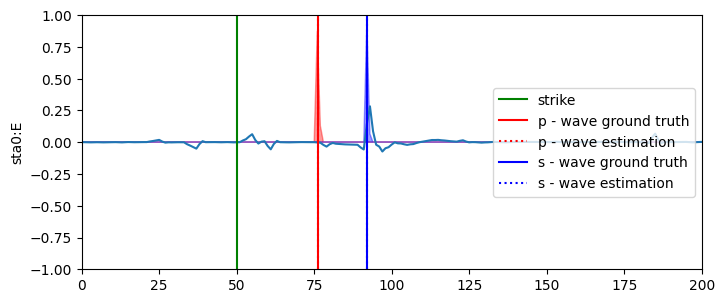

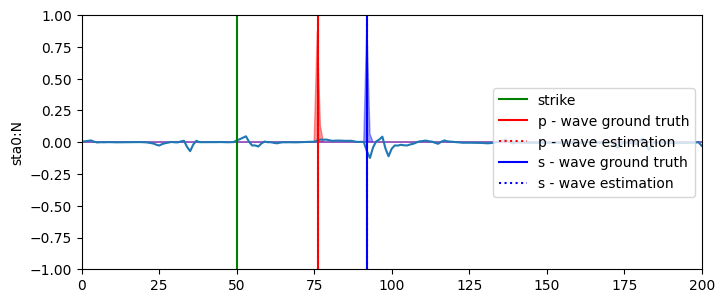

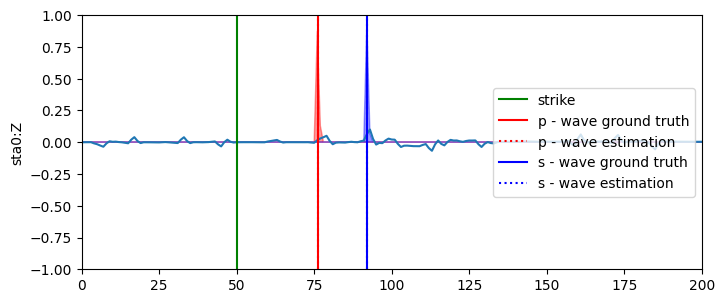

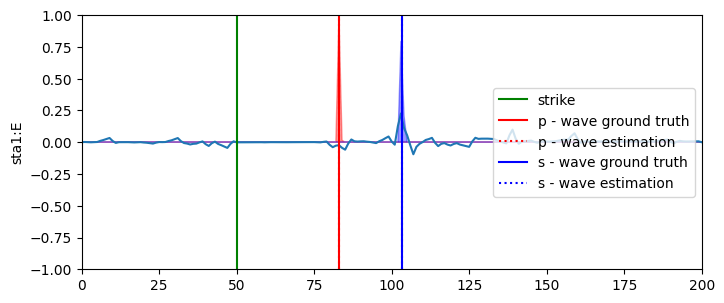

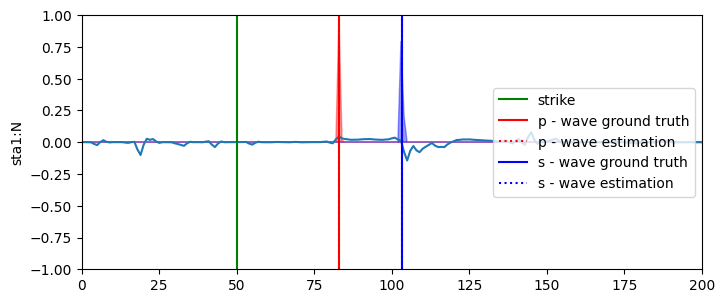

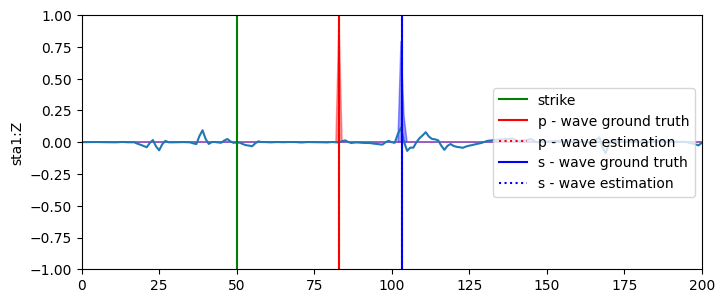

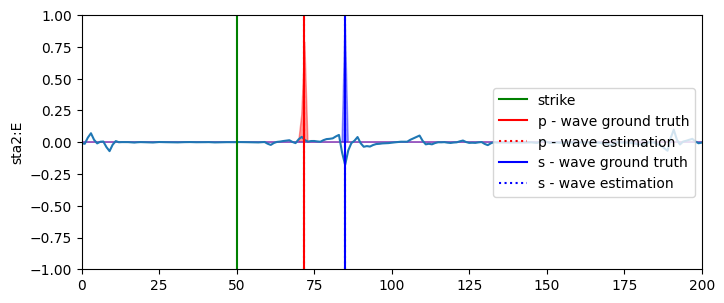

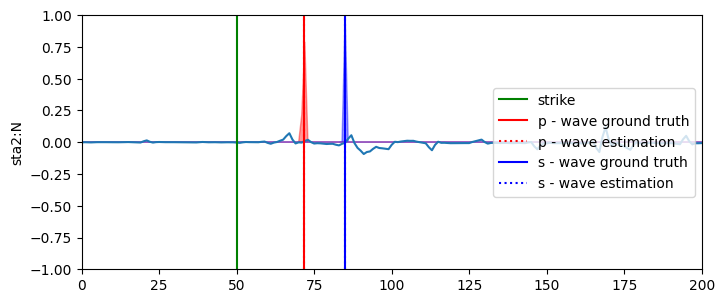

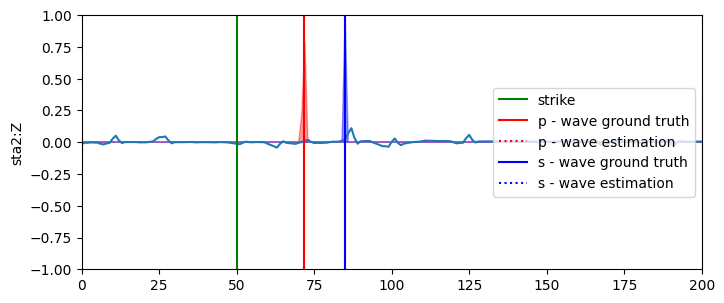

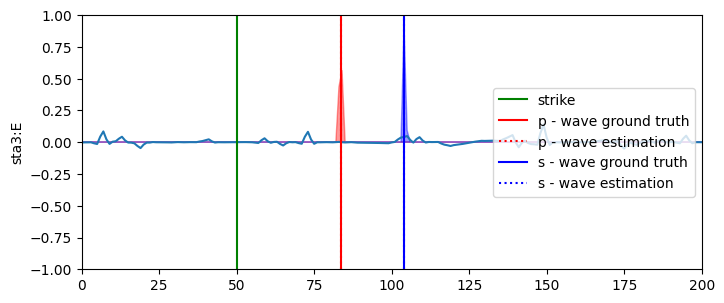

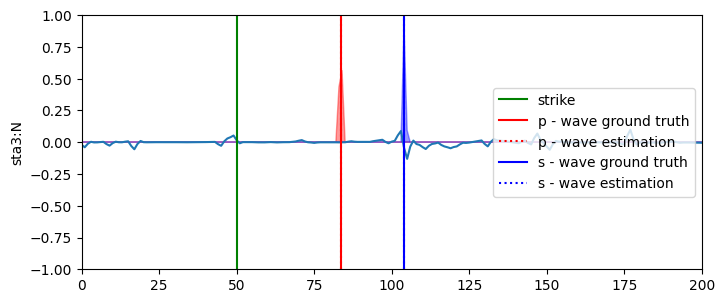

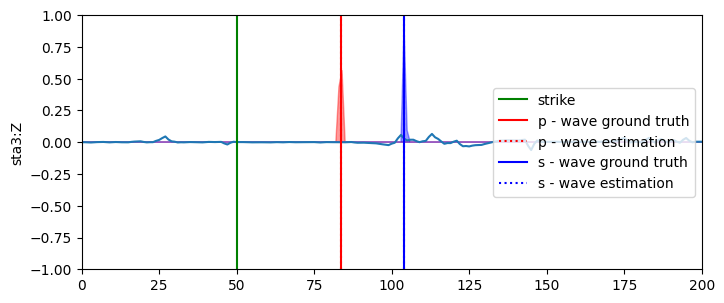

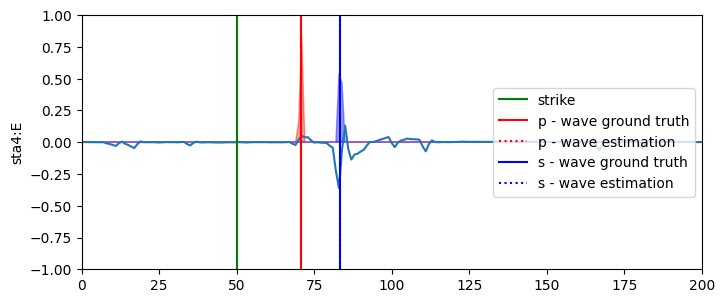

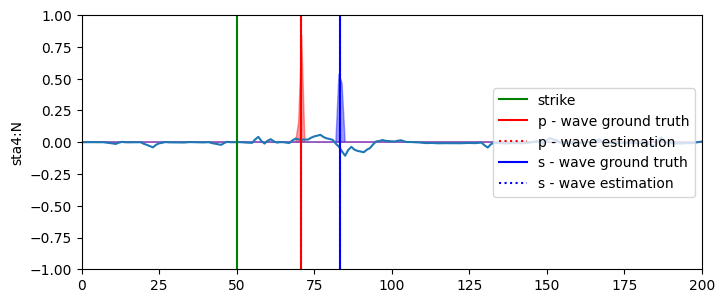

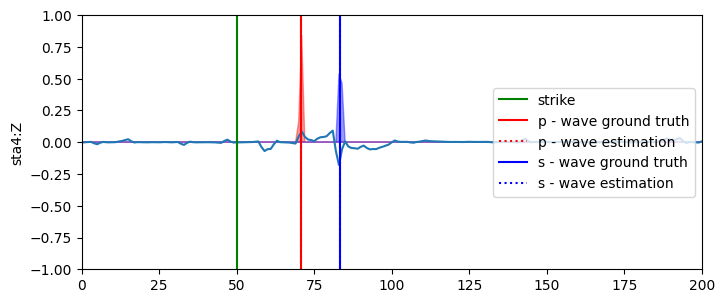

In [44]:
transforms = stack_transforms([ToTensor(),
                               Normalizer(),
                               ToOneHot(), 
                               AddNoize(0.001),
                               AddCorrelatedNoize(0.001),
                               Spikes(sigma=0.1, fraction = 0.1, variate=True),
                               WtFilter(cl=[-1]),
                               ])


dataset = SynthSeism(h5_path = train_h5_path, transforms=transforms)

# all is fine
dataloader = DataLoader(dataset=dataset,
                      batch_size=10,
                      shuffle=False,
                      collate_fn=dataset.collate_fn, 
                      )

for X, y in dataloader:
    plot_event(X[0], y[0])
    break

### –°–∞–º–∞ –º–æ–¥–µ–ª—å. 
–í –º–æ–¥–µ–ª–∏ –≤–∞–∂–Ω–∞ –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–º–µ–Ω—è—Ç—å –µ—ë –¥–ª—è –ø—Ä–æ–∏–∑–≤–æ–ª—å–Ω–æ–≥–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Å—Ç–∞–Ω—Ü–∏–π, –ø—Ä–∏ —ç—Ç–æ–º, –ø—Ä–∏ –æ–±—Ä–∞–±–æ—Ç–∫–µ –∫–∞–∂–¥–æ–π –æ—Ç–¥–µ–ª—å–Ω–æ–π –∑–∞–ø–∏—Å–∏, –¥–æ–ª–∂–Ω—ã —É—á–∏—Ç—ã–≤–∞—Ç—å—Å—è –≤—Å–µ –ø—Ä–æ—á–∏–µ. 

* –î–ª—è —Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏—è –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è Log-wavelet scattering transform –∏—Å—Ö–æ–¥–Ω–æ–≥–æ —Å–∏–≥–Ω–∞–ª–∞ [And√©n, Mallat, 2014]. –°–ª–æ–π Wavelet Scattering (WS) —Ñ–æ—Ä–º–∏—Ä—É–µ—Ç —á–∞—Å—Ç–æ—Ç–Ω–æ-–≤—Ä–µ–º–µ–Ω–Ω–æ–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏–µ —Å–∏–≥–Ω–∞–ª–∞ –Ω–∞ –æ—Å–Ω–æ–≤–µ –≤–µ–π–≤–ª–µ—Ç —Ä–∞–∑–ª–æ–∂–µ–Ω–∏—è, –æ—Ç—á–∞—Å—Ç–∏ –ø–æ—Ö–æ–∂–µ–µ –Ω–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç –æ–∫–æ–Ω–Ω–æ–≥–æ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è –§—É—Ä—å–µ. –ü—Ä–∏ —ç—Ç–æ–º WS –æ–±–ª–∞–¥–∞–µ—Ç –Ω–µ–æ–±—Ö–æ–¥–∏–º—ã–º–∏ —Å–≤–æ–π—Å—Ç–≤–∞–º–∏ —É—Å—Ç–æ–π—á–∏–≤–æ—Å—Ç–∏ –∫ –∏—Å–∫–∞–∂–µ–Ω–∏—è–º –∏—Å—Ö–æ–¥–Ω–æ–≥–æ —Å–∏–≥–Ω–∞–ª–∞, —Å–¥–≤–∏–≥–∞–º –ø–æ –≤—Ä–µ–º–µ–Ω–∏ –∏ –ª—É—á—à–µ–≥–æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –ø—Ä–∏ —Ä–∞–∑–ª–æ–∂–µ–Ω–∏–∏. –°–∞–º –∞–ª–≥–æ—Ä–∏—Ç–º –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è–µ—Ç —Å–æ–±–æ–π —Ä–µ–∫—É—Ä—Ä–µ–Ω—Ç–Ω—É—é –ø—Ä–æ—Ü–µ–¥—É—Ä—É, –≤ –∫–æ—Ç–æ—Ä–æ–π –∫ –∏—Å—Ö–æ–¥–Ω–æ–º—É —Å–∏–≥–Ω–∞–ª—É –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ –ø—Ä–∏–º–µ–Ω—è—é—Ç—Å—è –æ–ø–µ—Ä–∞—Ü–∏–∏ –≤–µ–π–≤–ª–µ—Ç-–ø–∞–∫–µ—Ç–Ω–æ–≥–æ —Ä–∞–∑–ª–æ–∂–µ–Ω–∏—è, –≤–∑—è—Ç–∏—è –∫–æ–º–ø–ª–µ–∫—Å–Ω–æ–≥–æ –º–æ–¥—É–ª—è –∏ —É—Å—Ä–µ–¥–Ω–µ–Ω–∏—è. –° —Ç–æ—á–∫–∏ –∑—Ä–µ–Ω–∏—è –Ω–µ–π—Ä–æ–Ω–Ω—ã—Ö —Å–µ—Ç–µ–π –¥–∞–Ω–Ω—ã–π —Å–ª–æ–π —è–≤–ª—è–µ—Ç—Å—è –∞–Ω–∞–ª–æ–≥–æ–º —Å–≤–µ—Ä—Ç–æ—á–Ω—ã—Ö —Å–ª–æ–µ–≤ –∏ –æ–ø–µ—Ä–∞—Ü–∏–π –ø—É–ª–ª–∏–Ω–≥–∞. –ù–æ, –µ—Å–ª–∏ –≤ —Å–≤–µ—Ä—Ç–æ—á–Ω–æ–º —Å–ª–æ–µ —Ñ–∏–ª—å—Ç—Ä—ã –ø—Ä–æ—Ö–æ–¥—è—Ç –ø—Ä–æ—Ü–µ–¥—É—Ä—É –æ–±—É—á–µ–Ω–∏—è, —Ç–æ –≤ —Å–ª—É—á–∞–µ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è WS –æ–Ω–∏ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω—ã –Ω–∞–±–æ—Ä–æ–º –≤–µ–π–≤–ª–µ—Ç–æ–≤, —á—Ç–æ —Å–Ω–∏–º–∞–µ—Ç –Ω–µ–æ–ø—Ä–µ–¥–µ–ª—ë–Ω–Ω–æ—Å—Ç—å, —Å–≤—è–∑–∞–Ω–Ω—É—é —Å –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ—Å—Ç—å—é –æ–±—É—á–µ–Ω–∏—è —Ñ–∏–ª—å—Ç—Ä–æ–≤. –í –∫–∞—á–µ—Å—Ç–≤–µ —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ WS –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–ª–∞—Å—å –±–∏–±–ª–∏–æ—Ç–µ–∫–∞ Kymatio [Andreux –∏ –¥—Ä., 2020].
* –í —Ä–µ–∑—É–ª—å—Ç–∞—Ç–µ –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è WS –∫–∞–∂–¥—ã–π —Å–∏–≥–Ω–∞–ª –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ—Ç—Å—è –≤ 2D —Ç–µ–Ω–∑–æ—Ä —Å –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏. –ü–æ—Å–ª–µ —ç—Ç–æ–≥–æ –ø—Ä–º–µ–Ω—è–µ—Ç—Å—è –¥–≤—É–º–µ—Ä–Ω–∞—è —Å–≤—ë—Ä—Ç–∫–∞ —Å –µ–¥–∏–Ω–∏—á–Ω—ã–º —Ä–∞–∑–º–µ—Ä–æ–º —è–¥—Ä–∞, –ø—Ä–µ–æ–±—Ä–∞–∑—É—é—â–∞—è —Ç—Ä–∏ –∫–∞–Ω–∞–ª–∞ –∑–∞–ø–∏—Å–∏ –∫–∞–∂–¥–æ–π —Å—Ç–∞–Ω—Ü–∏–∏ –≤ –æ–¥–∏–Ω.
* –ü–µ—Ä–≤—ã–π —Å–ª–æ–π —Ç—Ä–∞–Ω—Å—Ñ–æ–º–µ—Ä —ç–Ω–∫–æ–¥–µ—Ä–∞. 2D –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏–µ –∫–∞–∂–¥–æ–≥–æ –æ—Ç–¥–µ–ª—å–Ω–æ —Å–∏–≥–Ω–∞–ª–∞ –¥–µ–ª–∏—Ç—Å—è –Ω–∞ –≤—Ä–µ–º–µ–Ω–Ω—ã–µ —Ñ—Ä–µ–π–º—ã –∏ –ø–æ–¥–∞—ë—Ç—Å—è –≤ —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–µ—Ä —ç–Ω–∫–æ–¥–µ—Ä –¥–ª—è –ª—É—á—à–µ–≥–æ –≤—ã–¥–µ–ª–µ–Ω–∏—è –æ–±–ª–∞—Å—Ç–∏, –≤ –∫–æ—Ç–æ—Ä–æ–π –Ω–∞—Ö–æ–¥–∏—Ç—Å—è —Å–∏–≥–Ω–∞–ª.
* –í—Ç–æ—Ä–æ–π —Å–ª–æ–π —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–µ—Ä —ç–Ω–∫–æ–¥–µ—Ä–∞. –ü—Ä–∏–º–µ–Ω—è–µ—Ç—Å—è –∫ –∑–∞–ø–∏—Å—è–º –≥—Ä—É–ø–ø—ã —Å—Ç–∞–Ω—Ü–∏–π –¥–ª—è –æ–±–º–µ–Ω–∞ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –º–µ–∂–¥—É –Ω–∏–º–∏.
* –í—ã—Ö–æ–¥ —Å–ª–æ—è —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–µ—Ä–∞ –ø–æ–ø–∞–¥–∞–µ—Ç –Ω–∞ –ø–æ–ª–Ω–æ—Å–≤—è–∑–Ω—ã–π —Å–ª–æ–πb –∏ —Å–∏–≥–º–æ–∏–¥—É. –ù–∞ –≤—ã—Ö–æ–¥–µ –∏–∑ –º–æ–¥–µ–ª–∏ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Å–æ–±—ã—Ç–∏—è –ø–æ–ª—É—á–∞–µ—Ç—Å—è 2D —Ç–µ–Ω–∑–æ—Ä –∏–∑ one-hot –≤–µ–∫—Ç–æ—Ä–æ–≤. –†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Ç–µ–Ω–∑–æ—Ä–∞ - (–∫–æ–ª–∏—á—Å—Ç–≤–æ —Å—Ç–∞–Ω—Ü–∏–π, –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ñ–∞–∑ (p –∏ s)).

–¢–∞–∫–∂–µ –≤ —ç—Ç–æ–º –±–ª–æ–∫–µ –ø–µ—Ä–µ–æ–ø—Ä–µ–¥–µ–ª—è–µ—Ç—Å—è –∫–ª–∞—Å—Å –ª–æ—Å—Å —Ñ—É–Ω–∫—Ü–∏–∏. –≠—Ç–æ –≤—Å—ë —Ç–æ—Ç –∂–µ BCELoss, –Ω–æ —Å –±–æ–ª—å—à–∏–º —à—Ç—Ä–∞—Ñ–æ–º –∑–∞ –Ω–µ—Å–æ–≤–ø–∞–¥–µ–Ω–∏–µ —Å –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã–º–∏ –º–µ—Ç–∫–∞–º–∏. –≠—Ç–æ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –∏–∑-–∑–∞ –Ω–µ—Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω–æ—Å—Ç–∏ —Ü–µ–ª–µ–≤—ã—Ö –≤–µ–∫—Ç–æ—Ä–æ–≤: –æ–¥–Ω–æ –∑–Ω–∞—á–µ–Ω–∏–µ —Å –º–µ—Ç–∫–æ–π 1 –Ω–∞ 399 –Ω—É–ª–µ–≤—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π.

![microseismic modeling sketch](./imgs/arr_model_1.drawio.png "The model structure")





In [26]:
class MySparseBCELoss(nn.Module):
    # Custom BCE loss. I need it because of unballanced targets
    def __init__(self, sparcity=1):
        super().__init__()
        self.sparcity = sparcity # approximate fraction of signals
        self.eps = 1e-6
        
    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        # fraction of y==1 labels multiplied by (1/self.sparcity)
        my_custom_bceloss = - torch.mean((1/self.sparcity) * target * torch.log(input + self.eps) +  torch.log(1-input + self.eps)) 
        return my_custom_bceloss

class LogScat(nn.Module):
    '''
    Log-wavelet scattering transform. See https://www.kymat.io/index.html
    (..., trace vector) -> (...,  scat_shape 2D tensor)
    '''
    def __init__(self, J, rec_len, Q):
        super().__init__()
        self.scattering = Scattering1D(J, rec_len, Q).to(device)
        self.eps = 1e-6

    def forward(self, x):
        Sx = self.scattering(x)
        Sx[...,1:,:] = torch.log(torch.abs(Sx[...,1:,:]) + self.eps) # log for all coeffs except 0 order
        return Sx, self.scattering.meta()


class Conv_3_to_1(nn.Module):
    ''' 
    'Grayscale' chanels
    (..., ch num, scat_shape 2D tensor) -> (..., 1, scat_shape 2D tensor)
    '''
    def __init__(self, ch_in):
        super().__init__()
        self.conv = nn.Conv2d(ch_in, 1, 1)
    
    def forward(self, x):
        sh_x = x.shape
        x = x.flatten(0,1)
        x = self.conv(x) 
        x = x.unflatten(0, (sh_x[0], sh_x[1]))
        return x


class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        pad = int(d_model % 2) # one or zero
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model+pad)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        pe = pe[...,:d_model]
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[0,:x.size(1),:]
        return x


class OneTraceTransformerEncoder(nn.Module):
    '''
    Performs attention over each single trace 
    (batch, sta num, scattering 2D) -> (batch, sta num, scattering flat vector time, scattering flat vector order) -> (batch, sta num, scattering 2D)
    size of emb vector ==  size of scattering flat vector
    '''
    def __init__(self, scat_shape, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.emb_size = scat_shape[0]
        self.pos_encoding = PositionalEncoding(self.emb_size)
        self.encoder_layer = nn.TransformerEncoderLayer(self.emb_size, 1, batch_first=True) # one head. emb size is unpredictable 
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, self.num_layers)
    
    def forward(self, x):
        sh_x = x.shape 
        x = x.flatten(0,1) # batch, sta -> -1
        x = x.transpose(-1,-2) # scattering (order, time) <-> (time, order)   
        x = self.pos_encoding(x)
        x = self.transformer_encoder(x)       
        x = x.transpose(-1,-2)
        x = x.unflatten(0, (sh_x[0], sh_x[1]))
        return x


class StaTransformerEncoder(nn.Module):
    '''
    Performs attention over the group of stantions
    (batch, sta num, scattering flat vector) -> (batch, sta num, emb vector)
    size of emb vector ==  size of scattering flat vector
    '''
    def __init__(self, scat_shape, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.emb_size = scat_shape[0] * scat_shape[1]
        self.nheads = scat_shape[0]
        self.encoder_layer = nn.TransformerEncoderLayer(self.emb_size, self.nheads, batch_first=True) # 16x50
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, self.num_layers)
    
    def forward(self, x):
        return self.transformer_encoder(x)


class Fc(nn.Module):
    '''
    embeddings to outs (batch, sta num, emb vector) -> (batch, sta num, target tensor)
    '''
    def __init__(self, emb_size, rec_len, fc_drop=0.1):
        super().__init__()
        self.emb_size = emb_size
        self.rec_len = rec_len
        self.fc1 = nn.Linear(self.emb_size, 2*self.rec_len) 
        self.relu = nn.ReLU() 
        self.drop = nn.Dropout(fc_drop) 
        self.fc2 = nn.Linear(2*self.rec_len, 2*self.rec_len) 
        self.fc3 = nn.Linear(2*self.rec_len, 2*self.rec_len) 
        self.sigm = nn.Sigmoid()
    
    def forward(self, x):
        bs = x.shape[0] # batch size
        x = x.flatten(0,1)
        x = self.drop(self.relu(self.fc1(x)))
        x = self.drop(self.relu(self.fc2(x)))
        x = self.fc3(x)
        x = self.sigm(x)
        x = x.view(bs, -1, 2, self.rec_len) # 2 phases 
        return x


class Arrivals(nn.Module):
    '''
    Model itself
    waveforms -> arrivals
    '''
    def __init__(self, chanels, rec_len, one_tr_attn_nlayer, sta_attn_nlayer, fc_drop, J, Q):
        super().__init__()
        self.rec_len = rec_len
        self.scattering = LogScat(J=J, rec_len=rec_len, Q=Q) # scattering
        self.scat_shape, self.meta = self.get_scat_shape()
        self.conv_3ch = Conv_3_to_1(chanels) # conv 3 ch -> 1 ch
        # one trace cross attention
        self.one_tr_transf = OneTraceTransformerEncoder(self.scat_shape, one_tr_attn_nlayer) 
        # stantion cross attention
        self.sta_transf = StaTransformerEncoder(self.scat_shape, sta_attn_nlayer)
        emb_size =  self.sta_transf.emb_size  # equal to flat scatt size
        self.fc = Fc(emb_size, rec_len, fc_drop)

    def forward(self, x):
        x, meta = self.scattering(x) # scattering
        x = self.conv_3ch(x).squeeze(-3) # 3 ch to one
        x = self.one_tr_transf(x) # attention over each singl trace 
        x = x.flatten(-2,-1) # img to line
        x = self.sta_transf(x) # attention over the group of stantions
        x = self.fc(x)
        return x

    def get_scat_shape(self):
        # returns scattering output shape
        foo = torch.randn(self.rec_len).to(device)
        bar, meta = self.scattering(foo)
        return bar.shape, meta



## –ö–ª–∞—Å—Å –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –∏ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ –º–æ–¥–µ–ª–∏ –≤—ã–¥–µ–ª–µ–Ω–∏—è —Ñ–∞–∑.

In [72]:
class ArrNetwork:
    def __init__(self, train_h5_path, test_h5_path, params):
        use_cuda = torch.cuda.is_available()
        self.device = device = torch.device("cuda" if use_cuda else "cpu")
        self.params = params
        self.train_dl, self.test_dl = dataset_creator(train_h5_path, test_h5_path, params)
        self.model = Arrivals(params.ch, params.rec_len, params.one_tr_attn_nlayer, params.sta_attn_nlayer, params.fc_drop, params.J, params.Q).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=params.lr)
        self.loss = MySparseBCELoss(params.sparcity)
    
    def __call__(self, X):
        self.model.eval()
        X = X.to(self.device)
        y_hat = self.model(X)
        return y_hat

    def evaluate(self):
        self.model.eval()
        for X, y_list_of_dicts in self.test_dl:
            y = torch.stack([yy['oh_arrivals'].to(self.device) for yy in y_list_of_dicts]) # target is a dict with all staf
            X = X.to(self.device)
            y_hat = self.model(X)
            l = self.loss(y_hat, y)
            break # one batch only 
        return l.item()

    def evaluate_time_error(self):
        self.model.eval()
        for X, y_list_of_dicts in self.test_dl:
            X = X.to(self.device)
            y_hat_oh = self.model(X)
            p_err, s_err = time_error(y_list_of_dicts, y_hat_oh)
            break # one batch only 

        return p_err, s_err
         
    def train(self):
        metrics = {'loss':{'train': [], 'val': []}, 'epoch': []} 
        for epoch in tqdm(range(self.params.epochs)):
            losses = self.train_one_epoch()
            wandb.log(losses) # wandb here
            metrics['epoch'].append(epoch)
            metrics['loss']['train'].append(losses['train'])
            metrics['loss']['val'].append(losses['val'])
            if epoch % 1 == 0:
                print(f"Epoch {epoch}:: train loss: {metrics['loss']['train'][-1]:.04f}, val loss: {metrics['loss']['val'][-1]:.04f}")
        return metrics

    def train_one_epoch(self):
        self.model.train()
        for X, y_list_of_dicts in tqdm(self.train_dl):
            y = torch.stack([yy['oh_arrivals'].to(self.device) for yy in y_list_of_dicts]) # target is a dict with all staf
            X = X.to(self.device)
            y_hat = self.model(X)
            l = self.loss(y_hat, y)
            self.optimizer.zero_grad()
            l.backward()
            self.optimizer.step()
        losses = {'train': l.item(), 'val': self.evaluate()}
        return losses

    def get_weights(self):
        return self.model.state_dict()

    def set_weights(self, pt_path):
        self.model.load_state_dict(torch.load(pt_path, map_location=torch.device(self.device)))

    def save(self, state_name=''):
        pt_path = f'{CURR_DIR}/model_states/{state_name}{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.pt'
        torch.save(self.model.state_dict(), pt_path)

def time_error(y_list_of_dicts, y_hat_oh):
    mse_loss =  nn.MSELoss(reduction = 'mean')
    s_rate = y_list_of_dicts[0]['params']['s_rate']
    y = torch.stack([yy['arrivals'][...,1:] for yy in y_list_of_dicts]).unsqueeze(-1) # target is a dict with all staf
    y_hat = oh_to_sec(y_hat_oh)/s_rate

    p_err = torch.sqrt(mse_loss(y[...,0,:], y_hat[...,0,:])).item()
    s_err = torch.sqrt(mse_loss(y[...,1,:], y_hat[...,1,:])).item()
    return p_err, s_err

def oh_to_sec(oh):
    # transforms oh arrivals to dence arrivals (in samples)
    probs = oh[...,:-1] + oh[...,1:]
    fracs_tens = oh[...,1:] / probs
    argmaxes = torch.argmax(probs, dim=-1).unsqueeze(-1)
    fractions = fracs_tens.gather(-1, argmaxes) 
    arrivals = argmaxes + fractions
    return arrivals

def dataset_creator(train_h5_path, test_h5_path, params):
    # creates dataloaders 
    train_transforms = stack_transforms([ToTensor(),
                               Normalizer(),
                               ToOneHot(),
                               AddNoize(params.train_noise_sigma, params.variate),
                               AddCorrelatedNoize(params.train_corr_noise_sigma, params.variate),
                               Spikes(params.train_spikes_sigma, params.train_spikes_fraction, params.variate),
                               WtFilter(params.cl),
                               ])
    
    test_transforms = stack_transforms([ToTensor(),
                               Normalizer(),
                               ToOneHot(),
                               AddNoize(params.val_noise_sigma),
                               AddCorrelatedNoize(params.val_corr_noise_sigma),
                               Spikes(params.val_spikes_sigma, params.val_spikes_fraction),
                               WtFilter(params.cl),
                               ])

    train = SynthSeism(h5_path = train_h5_path, transforms=train_transforms)
    test = SynthSeism(h5_path = test_h5_path, transforms=test_transforms)

    # this is for testing
    # train = torch.utils.data.Subset(train, torch.randperm(2000).tolist())


    train_dl = DataLoader(dataset=train,
                          batch_size=params.batch_size,
                          shuffle=True,
                          collate_fn=test.collate_fn,  # test -> train here if using Subset
                          )

    test_dl = DataLoader(dataset=test,
                          batch_size=params.batch_size,
                          shuffle=False,
                          collate_fn=test.collate_fn, 
                          )

    return train_dl, test_dl

class BaseConfig:
    def __init__(self, **kwargs):
        # default model params
        self.ch=3
        self.rec_len=400
        self.one_tr_attn_nlayer=2
        self.sta_attn_nlayer=3
        self.fc_drop=0.0
        self.J=3
        self.Q=6

        # default training params
        self.batch_size = 100
        self.epochs = 5
        self.lr = 0.0001
        self.sparcity = 0.0025

        # default transform params
        self.train_noise_sigma = 0.0
        self.train_corr_noise_sigma = 0.0
        self.train_spikes_sigma = 0.0
        self.train_spikes_fraction = 0.0

        self.variate = False 
        
        self.val_noise_sigma = 0.0
        self.val_corr_noise_sigma = 0.0
        self.val_spikes_sigma = 0.0
        self.val_spikes_fraction = 0.0

        self.cl = [-1]

        # kwargs to attrs
        self.__dict__.update(kwargs)


## Ray and Wandb here

In [ ]:
!wandb login # key is needed

wandb: Currently logged in as: nabarysh. Use `wandb login --relogin` to force relogin


In [ ]:
import ray
from ray import air, tune
from ray.air import session
from ray.tune.schedulers import ASHAScheduler
from ray.air.integrations.wandb import setup_wandb

def trial_my_net(config):
    params = BaseConfig(**config)
    params.train_corr_noise_sigma = params.train_noise_sigma # same noize
    trial_id = session.get_trial_id()
    net = ArrNetwork(train_h5_path, test_h5_path, params)
    to_wandb_dict = {'t_id': trial_id}
    to_wandb_dict.update(params.__dict__)
    wandb = setup_wandb(to_wandb_dict, rank_zero_only=False, **params.wandb) # stupid ray docs
    for epoch in range(params.epochs):
        losses = net.train_one_epoch()
        wandb.log(losses)
        session.report(losses)

    net.save(f'{trial_id}_') # saving model state
    wandb.finish()
     

def tune_my_model(config, num_samples): #, max_num_epochs, time_budget_s):
    trainable = tune.with_resources(
        tune.with_parameters(trial_my_net), 
        resources={'cpu':12, 'gpu':1}, # use !ray status
        ) 


    scheduler = ASHAScheduler(
        # max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
        )
    
    tune_config = tune.TuneConfig(
        metric="train",
        mode="min",
        # scheduler=scheduler,
        num_samples=num_samples,
        # time_budget_s = time_budget_s, # must be num_samples=-1 
        )
    
    param_space=config
    
    tuner = tune.Tuner(
        trainable=trainable, 
        tune_config=tune_config, 
        param_space=param_space,
        )
    
    results = tuner.fit()
    return results

## –ü–ª–∞–Ω –ø–æ —Ç–µ—Å—Ç–∞–º
* —Ç–µ—Å—Ç –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ —Å–∫–µ—Ç—Ç–µ—Ä–∏–Ω–≥–∞ –∏ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Å–ª–æ—ë–≤ –≤–Ω–∏–º–∞–Ω–∏—è (1 —ç–ø–æ—Ö–∞):
        "one_tr_attn_nlayer": tune.grid_search([1,2,3]),
        "sta_attn_nlayer": tune.grid_search([1,2,3]),
        "J": tune.grid_search([3,4]),
        "Q": tune.grid_search([4,8]),

* —Ç–µ—Å—Ç Q (5 —ç–ø–æ—Ö)
        "Q": tune.grid_search([3, 4, 5, 6, 7, 8, 9, 10]),

* —Ç–µ—Å—Ç—ã –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ (5 —ç–ø–æ—Ö)
        "train_noise_sigma": tune.grid_search([0.0, 0.01]),
        "train_spikes_sigma": tune.grid_search([0.1]),
        "train_spikes_fraction": tune.grid_search([0.0, 0.1]),
        "variate": tune.grid_search([True, False]),





## tuning run

In [ ]:
config = {
            "train_noise_sigma": tune.grid_search([0.0, 0.01]),
            "train_spikes_sigma": tune.grid_search([0.1]),
            "train_spikes_fraction": tune.grid_search([0.0, 0.1]),
            "variate": tune.grid_search([True, False]),

            "epochs": 5,

            "wandb": {"project": "synth_wf_proc",
                    "group": "share_oh_augmentation",
                    }
            }

results = tune_my_model(config, num_samples=1) #, max_num_epochs=1, time_budget_s = 36000)

# Plotting ray tuning resulst
fig, ax = plt.subplots(figsize=(4.33, 3))

results_done = (r for r in results if r.metrics_dataframe is not None)
for result in results_done:
    result.metrics_dataframe.plot("training_iteration", "train", ax=ax, marker='.')

## –æ–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏

In [ ]:
!wandb login # key is needed

In [ ]:
%%time
# augmentation => add some noise and spikes
# params = BaseConfig(train_noise_sigma = 0.001,
#                     train_corr_noise_sigma = 0.001,
#                     train_spikes_sigma = 0.1,
#                     train_spikes_fraction = 0.1,
#                     epochs=1)

params = BaseConfig(epochs=30)

net = ArrNetwork(train_h5_path, test_h5_path, params) 

wandb.init(
    project="syth_wf_proc",
    name="train-no-aug",
    config=params.__dict__,
)

metrics = net.train()

wandb.finish()
plot_metrics(metrics)

#saving path
state_name = 'no_aug'
net.save(state_name)

# copy it to gdrive 
# !mkdir -p /gdrive/MyDrive/seismo_datasets/model_states/ && cp {pt_path} /gdrive/MyDrive/seismo_datasets/model_states/

## –ü—Ä–æ–≤–µ—Ä–∫–∞ —Ä–∞–±–æ—á–µ—Å—Ç–∏ –º–æ–¥–µ–ª–∏

Time error: p: 0.012891370803117752, s: 0.01455850712954998


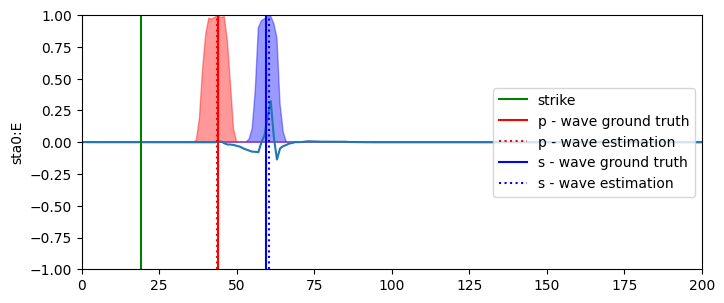

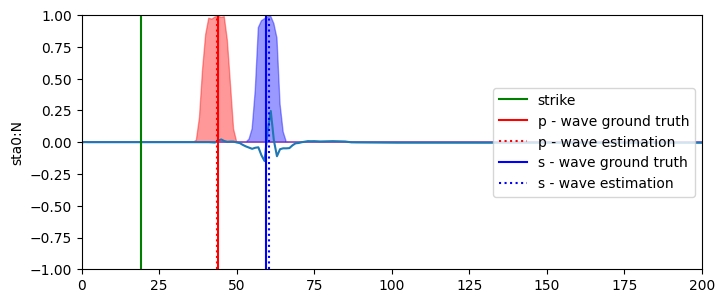

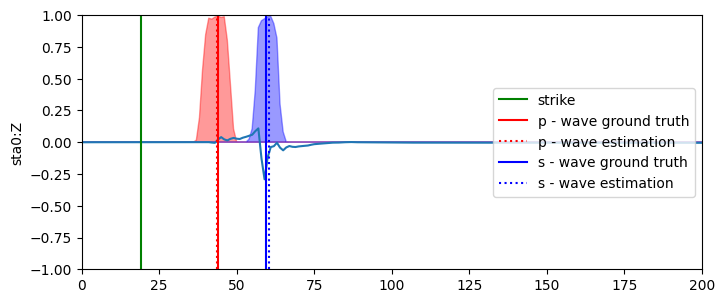

In [79]:
%matplotlib inline
params = BaseConfig()
net = ArrNetwork(train_h5_path, test_h5_path, params) 
pt_path = f'{CURR_DIR}/model_states/c5342_00000_04_18_2023__10_55_59.pt'
net.set_weights(pt_path)

X, Y = next(iter(net.test_dl))
x, y = X[42], Y[42]

y_hat = net(x.unsqueeze(0)).detach().cpu()

p_err, s_err = time_error([y], y_hat) # y is list of dicts, y_hat in batces
print(f'Time error: p: {p_err}, s: {s_err}')

plot_sta('sta0', x, y, y_hat.squeeze(0))

## –ü—Ä–æ–≤–µ—Ä–∫–∞ –º–æ–¥–µ–ª–∏ –Ω–∞ —É—Å—Ç–æ–π—á–∏–≤–æ—Å—Ç—å –∫ —à—É–º—É –¥–ª—è —Ä–∞–∑–Ω—ã—Ö —Ç–∏–ø–∞–≤ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏

In [98]:
!wandb login # key is needed

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [99]:
# noize testing
# state dict folder -> noise graph 
from ray import tune
from ray.air.integrations.wandb import setup_wandb

def noize_trial(config):
    st_path = config['state_path']
    state_name = '_'.join(st_path.split('/')[-1].split("_")[0:2])
  
    wandb = setup_wandb({'state_name': state_name}, rank_zero_only=False, **config['wandb']) # stupid ray docs
    for sigma in config['sigmas']:
       
        params = BaseConfig(val_noise_sigma=sigma, val_corr_noise_sigma=sigma)
        net = ArrNetwork(train_h5_path, test_h5_path, params) 
        net.set_weights(st_path)
        l = net.evaluate()
        p_err, s_err = net.evaluate_time_error()

        wandb.log({'sigma': sigma, 'val': l, 'p_err': p_err, 's_err': s_err})

    wandb.finish()

listdir = glob.glob(f"{CURR_DIR}/model_states/*")
sigmas = np.concatenate((np.zeros(1), np.logspace(-3, 0, num=10)))/3

config = {  "state_path": tune.grid_search(listdir),
            "sigmas": sigmas,

            "wandb": {"project": "ray-testing",
                    "group": "noize_ps",
                    }
            }

tuner = tune.Tuner(noize_trial, param_space=config) 
tuner.fit()

2023-04-20 11:09:03,068	INFO worker.py:1553 -- Started a local Ray instance.


(noize_trial pid=35899) 2023-04-20 11:09:20,640	INFO wandb.py:314 -- Already logged into W&B.
(noize_trial pid=35899) wandb: Currently logged in as: nabarysh. Use `wandb login --relogin` to force relogin
(noize_trial pid=35899) wandb: Tracking run with wandb version 0.15.0
(noize_trial pid=35899) wandb: Run data is saved locally in /root/ray_results/noize_trial_2023-04-20_11-08-59/noize_trial_c31c7_00000_0_state_path=content_model_states_94685_00001_04_19_2023__12_34_02_pt_2023-04-20_11-09-09/wandb/run-20230420_110923-c31c7_00000
(noize_trial pid=35899) wandb: Run `wandb offline` to turn off syncing.
(noize_trial pid=35899) wandb: Syncing run noize_trial_c31c7_00000
(noize_trial pid=35899) wandb: ‚≠êÔ∏è View project at https://wandb.ai/nabarysh/ray-testing
(noize_trial pid=35899) wandb: üöÄ View run at https://wandb.ai/nabarysh/ray-testing/runs/c31c7_00000
(noize_trial pid=36006) 2023-04-20 11:09:30,751	INFO wandb.py:314 -- Already logged into W&B.
(noize_trial pid=36006) wandb: Curre

Trial noize_trial_c31c7_00000 completed. Last result: 


(noize_trial pid=35899) wandb: 
(noize_trial pid=35899) wandb: Run history:
(noize_trial pid=35899) wandb: p_err ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÇ‚ñÑ‚ñá‚ñà
(noize_trial pid=35899) wandb: s_err ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÇ‚ñÑ‚ñá‚ñà
(noize_trial pid=35899) wandb: sigma ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÑ‚ñà
(noize_trial pid=35899) wandb:   val ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÖ‚ñà
(noize_trial pid=35899) wandb: 
(noize_trial pid=35899) wandb: Run summary:
(noize_trial pid=35899) wandb: p_err 0.47351
(noize_trial pid=35899) wandb: s_err 0.50587
(noize_trial pid=35899) wandb: sigma 0.33333
(noize_trial pid=35899) wandb:   val 1.8251
(noize_trial pid=35899) wandb: 
(noize_trial pid=35899) wandb: üöÄ View run noize_trial_c31c7_00000 at: https://wandb.ai/nabarysh/ray-testing/runs/c31c7_00000
(noize_trial pid=35899) wandb: Synced 4 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(noize_trial pid=35899) wandb: Find logs at: ./wandb/run-20230420_110923-c31c7_00000/logs
(noize_trial pid=35899) 20

Trial noize_trial_c31c7_00001 completed. Last result: 


(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: Run history:
(noize_trial pid=36006) wandb: p_err ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñá‚ñà
(noize_trial pid=36006) wandb: s_err ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñá‚ñà
(noize_trial pid=36006) wandb: sigma ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÑ‚ñà
(noize_trial pid=36006) wandb:   val ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÖ‚ñà
(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: Run summary:
(noize_trial pid=36006) wandb: p_err 0.44603
(noize_trial pid=36006) wandb: s_err 0.4467
(noize_trial pid=36006) wandb: sigma 0.33333
(noize_trial pid=36006) wandb:   val 9.12442
(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: üöÄ View run noize_trial_c31c7_00001 at: https://wandb.ai/nabarysh/ray-testing/runs/c31c7_00001
(noize_trial pid=36006) wandb: Synced 4 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(noize_trial pid=36006) wandb: Find logs at: ./wandb/run-20230420_110933-c31c7_00001/logs
(noize_trial pid=36006) 20

Trial noize_trial_c31c7_00002 completed. Last result: 


(noize_trial pid=35899) wandb: 
(noize_trial pid=35899) wandb: Run history:
(noize_trial pid=35899) wandb: p_err ‚ñÇ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÖ‚ñà‚ñà‚ñá
(noize_trial pid=35899) wandb: s_err ‚ñÇ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÖ‚ñà‚ñà‚ñá
(noize_trial pid=35899) wandb: sigma ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÑ‚ñà
(noize_trial pid=35899) wandb:   val ‚ñÖ‚ñÇ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÑ‚ñÜ‚ñá‚ñà
(noize_trial pid=35899) wandb: 
(noize_trial pid=35899) wandb: Run summary:
(noize_trial pid=35899) wandb: p_err 0.50102
(noize_trial pid=35899) wandb: s_err 0.61135
(noize_trial pid=35899) wandb: sigma 0.33333
(noize_trial pid=35899) wandb:   val 4.15909
(noize_trial pid=35899) wandb: 
(noize_trial pid=35899) wandb: üöÄ View run noize_trial_c31c7_00002 at: https://wandb.ai/nabarysh/ray-testing/runs/c31c7_00002
(noize_trial pid=35899) wandb: Synced 4 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(noize_trial pid=35899) wandb: Find logs at: ./wandb/run-20230420_111228-c31c7_00002/logs
(noize_trial pid=35899) 2

Trial noize_trial_c31c7_00003 completed. Last result: 


(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: Run history:
(noize_trial pid=36006) wandb: p_err ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÜ‚ñà
(noize_trial pid=36006) wandb: s_err ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÜ‚ñà
(noize_trial pid=36006) wandb: sigma ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÑ‚ñà
(noize_trial pid=36006) wandb:   val ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÑ‚ñà
(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: Run summary:
(noize_trial pid=36006) wandb: p_err 0.49196
(noize_trial pid=36006) wandb: s_err 0.52592
(noize_trial pid=36006) wandb: sigma 0.33333
(noize_trial pid=36006) wandb:   val 4.07185
(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: üöÄ View run noize_trial_c31c7_00003 at: https://wandb.ai/nabarysh/ray-testing/runs/c31c7_00003
(noize_trial pid=36006) wandb: Synced 4 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(noize_trial pid=36006) wandb: Find logs at: ./wandb/run-20230420_111233-c31c7_00003/logs
(noize_trial pid=36006) 2

Trial noize_trial_c31c7_00004 completed. Last result: 


(noize_trial pid=35899) wandb: 
(noize_trial pid=35899) wandb: Run history:
(noize_trial pid=35899) wandb: p_err ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ
(noize_trial pid=35899) wandb: s_err ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ
(noize_trial pid=35899) wandb: sigma ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÑ‚ñà
(noize_trial pid=35899) wandb:   val ‚ñÅ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÉ‚ñÜ‚ñÜ‚ñÜ‚ñá‚ñà
(noize_trial pid=35899) wandb: 
(noize_trial pid=35899) wandb: Run summary:
(noize_trial pid=35899) wandb: p_err 0.3911
(noize_trial pid=35899) wandb: s_err 0.31587
(noize_trial pid=35899) wandb: sigma 0.33333
(noize_trial pid=35899) wandb:   val 0.7174
(noize_trial pid=35899) wandb: 
(noize_trial pid=35899) wandb: üöÄ View run noize_trial_c31c7_00004 at: https://wandb.ai/nabarysh/ray-testing/runs/c31c7_00004
(noize_trial pid=35899) wandb: Synced 4 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(noize_trial pid=35899) wandb: Find logs at: ./wandb/run-20230420_111527-c31c7_00004/logs
(noize_trial pid=35899) 202

Trial noize_trial_c31c7_00005 completed. Last result: 


(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: Run history:
(noize_trial pid=36006) wandb: p_err ‚ñÑ‚ñÇ‚ñÅ‚ñÇ‚ñÇ‚ñÉ‚ñÉ‚ñÅ‚ñÇ‚ñÖ‚ñà
(noize_trial pid=36006) wandb: s_err ‚ñÖ‚ñÇ‚ñÇ‚ñÇ‚ñÉ‚ñÉ‚ñÉ‚ñÅ‚ñÇ‚ñÖ‚ñà
(noize_trial pid=36006) wandb: sigma ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÑ‚ñà
(noize_trial pid=36006) wandb:   val ‚ñÇ‚ñÇ‚ñÇ‚ñÅ‚ñÇ‚ñÇ‚ñÇ‚ñÅ‚ñÇ‚ñÖ‚ñà
(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: Run summary:
(noize_trial pid=36006) wandb: p_err 0.40762
(noize_trial pid=36006) wandb: s_err 0.42953
(noize_trial pid=36006) wandb: sigma 0.33333
(noize_trial pid=36006) wandb:   val 1.58666
(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: üöÄ View run noize_trial_c31c7_00005 at: https://wandb.ai/nabarysh/ray-testing/runs/c31c7_00005
(noize_trial pid=36006) wandb: Synced 4 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(noize_trial pid=36006) wandb: Find logs at: ./wandb/run-20230420_111532-c31c7_00005/logs
(noize_trial pid=36006) 2

Trial noize_trial_c31c7_00006 completed. Last result: 


(noize_trial pid=35899) wandb: - Waiting for wandb.init()...
(noize_trial pid=35899) wandb: \ Waiting for wandb.init()...
(noize_trial pid=35899) wandb: Tracking run with wandb version 0.15.0
(noize_trial pid=35899) wandb: Run data is saved locally in /root/ray_results/noize_trial_2023-04-20_11-08-59/noize_trial_c31c7_00008_8_state_path=content_model_states_94685_00002_04_19_2023__13_50_19_pt_2023-04-20_11-21-59/wandb/run-20230420_112159-c31c7_00008
(noize_trial pid=35899) wandb: Run `wandb offline` to turn off syncing.
(noize_trial pid=35899) wandb: Syncing run noize_trial_c31c7_00008
(noize_trial pid=35899) wandb: ‚≠êÔ∏è View project at https://wandb.ai/nabarysh/ray-testing
(noize_trial pid=35899) wandb: üöÄ View run at https://wandb.ai/nabarysh/ray-testing/runs/c31c7_00008
(noize_trial pid=36006) wandb: Waiting for W&B process to finish... (success).


Trial noize_trial_c31c7_00007 completed. Last result: 


(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: Run history:
(noize_trial pid=36006) wandb: p_err ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÑ‚ñá‚ñà‚ñà‚ñà
(noize_trial pid=36006) wandb: s_err ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÉ‚ñá‚ñà‚ñà‚ñà
(noize_trial pid=36006) wandb: sigma ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÑ‚ñà
(noize_trial pid=36006) wandb:   val ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÖ‚ñÜ‚ñà
(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: Run summary:
(noize_trial pid=36006) wandb: p_err 0.37928
(noize_trial pid=36006) wandb: s_err 0.43296
(noize_trial pid=36006) wandb: sigma 0.33333
(noize_trial pid=36006) wandb:   val 4.70526
(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: üöÄ View run noize_trial_c31c7_00007 at: https://wandb.ai/nabarysh/ray-testing/runs/c31c7_00007
(noize_trial pid=36006) wandb: Synced 4 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(noize_trial pid=36006) wandb: Find logs at: ./wandb/run-20230420_111837-c31c7_00007/logs
(noize_trial pid=36006) 2

Trial noize_trial_c31c7_00008 completed. Last result: 


(noize_trial pid=35899) wandb: 
(noize_trial pid=35899) wandb: Run history:
(noize_trial pid=35899) wandb: p_err ‚ñÉ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÖ‚ñá‚ñà
(noize_trial pid=35899) wandb: s_err ‚ñÉ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÖ‚ñá‚ñà
(noize_trial pid=35899) wandb: sigma ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÑ‚ñà
(noize_trial pid=35899) wandb:   val ‚ñÇ‚ñÇ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÜ‚ñà
(noize_trial pid=35899) wandb: 
(noize_trial pid=35899) wandb: Run summary:
(noize_trial pid=35899) wandb: p_err 0.44839
(noize_trial pid=35899) wandb: s_err 0.48722
(noize_trial pid=35899) wandb: sigma 0.33333
(noize_trial pid=35899) wandb:   val 1.71766
(noize_trial pid=35899) wandb: 
(noize_trial pid=35899) wandb: üöÄ View run noize_trial_c31c7_00008 at: https://wandb.ai/nabarysh/ray-testing/runs/c31c7_00008
(noize_trial pid=35899) wandb: Synced 4 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(noize_trial pid=35899) wandb: Find logs at: ./wandb/run-20230420_112159-c31c7_00008/logs
(noize_trial pid=35899) 2

Trial noize_trial_c31c7_00009 completed. Last result: 


(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: Run history:
(noize_trial pid=36006) wandb: p_err ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÑ‚ñà‚ñà
(noize_trial pid=36006) wandb: s_err ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÑ‚ñà‚ñà
(noize_trial pid=36006) wandb: sigma ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÑ‚ñà
(noize_trial pid=36006) wandb:   val ‚ñÇ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÖ‚ñà
(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: Run summary:
(noize_trial pid=36006) wandb: p_err 0.33045
(noize_trial pid=36006) wandb: s_err 0.34588
(noize_trial pid=36006) wandb: sigma 0.33333
(noize_trial pid=36006) wandb:   val 1.64637
(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: üöÄ View run noize_trial_c31c7_00009 at: https://wandb.ai/nabarysh/ray-testing/runs/c31c7_00009
(noize_trial pid=36006) wandb: Synced 4 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(noize_trial pid=36006) wandb: Find logs at: ./wandb/run-20230420_112204-c31c7_00009/logs
(noize_trial pid=36006) 2

Trial noize_trial_c31c7_00010 completed. Last result: 


(noize_trial pid=36006) wandb: Waiting for W&B process to finish... (success).


Trial noize_trial_c31c7_00011 completed. Last result: 


(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: Run history:
(noize_trial pid=36006) wandb: p_err ‚ñÅ‚ñÇ‚ñÇ‚ñÉ‚ñÑ‚ñá‚ñà‚ñà‚ñà‚ñà‚ñá
(noize_trial pid=36006) wandb: s_err ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÑ‚ñÜ‚ñà‚ñà‚ñà‚ñà‚ñà
(noize_trial pid=36006) wandb: sigma ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÑ‚ñà
(noize_trial pid=36006) wandb:   val ‚ñÅ‚ñÑ‚ñÑ‚ñÑ‚ñÑ‚ñÖ‚ñá‚ñà‚ñà‚ñà‚ñà
(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: Run summary:
(noize_trial pid=36006) wandb: p_err 0.42725
(noize_trial pid=36006) wandb: s_err 0.56481
(noize_trial pid=36006) wandb: sigma 0.33333
(noize_trial pid=36006) wandb:   val 5.03082
(noize_trial pid=36006) wandb: 
(noize_trial pid=36006) wandb: üöÄ View run noize_trial_c31c7_00011 at: https://wandb.ai/nabarysh/ray-testing/runs/c31c7_00011
(noize_trial pid=36006) wandb: Synced 4 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(noize_trial pid=36006) wandb: Find logs at: ./wandb/run-20230420_112500-c31c7_00011/logs
2023-04-20 11:28:04,941	I

## –∫–∞—Ä—Ç–∏–Ω–∫–∏ –¥–ª—è –¥–≤—É—Ö –º–æ–¥–µ–ª–µ–∫

  0%|          | 0/5 [00:00<?, ?it/s]

0.040414951741695404
0.0263906791806221
0.04122408479452133
0.03576187044382095
0.09666700661182404
0.0803290605545044
0.2784528136253357
0.2958775758743286
0.3276315927505493
0.32987189292907715


  0%|          | 0/5 [00:00<?, ?it/s]

0.04693813994526863
0.03587660938501358
0.04070562124252319
0.03275618329644203
0.12869848310947418
0.13585370779037476
0.22174477577209473
0.22176241874694824
0.4384576082229614
0.4390324354171753


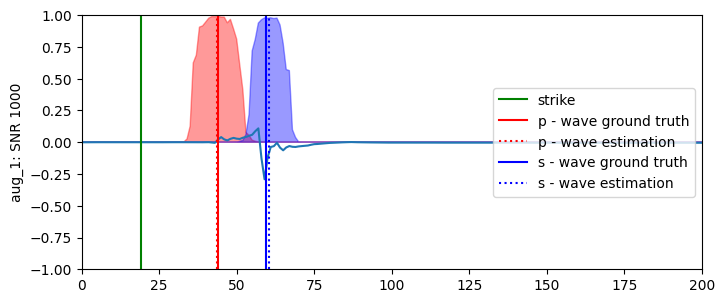

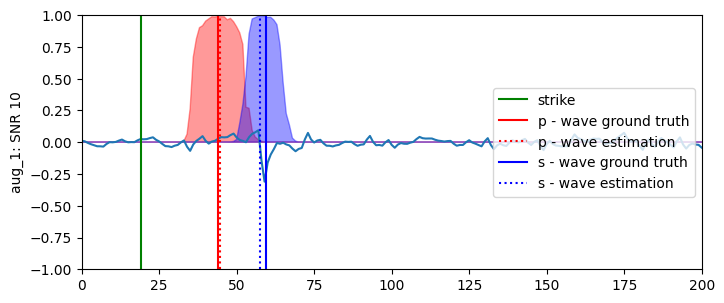

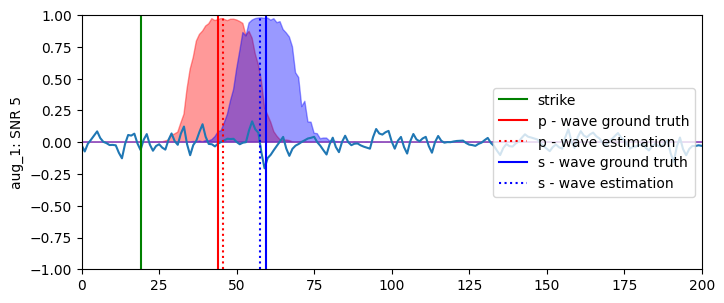

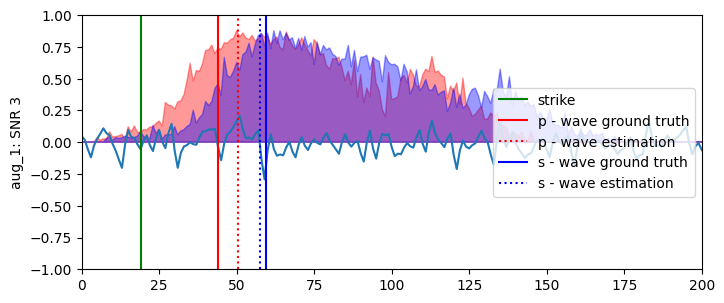

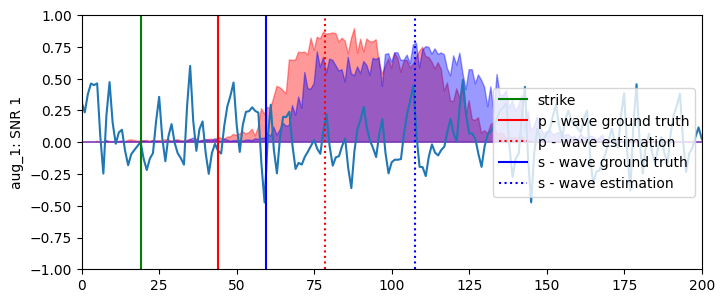

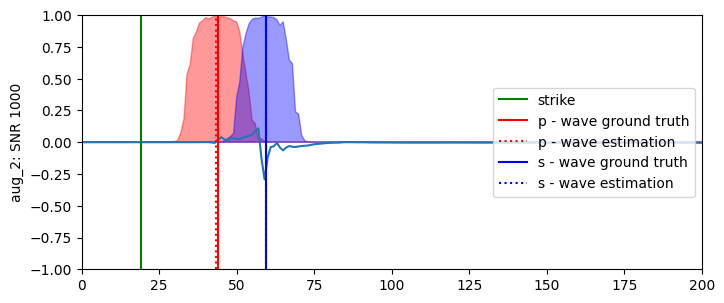

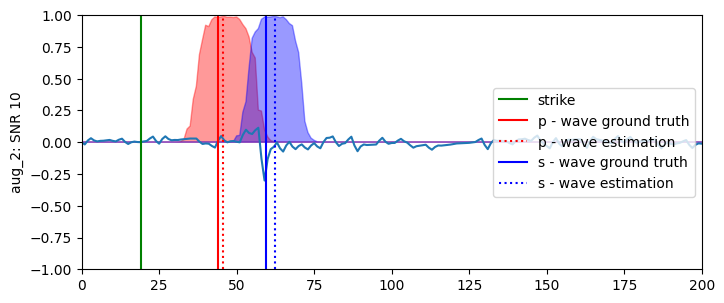

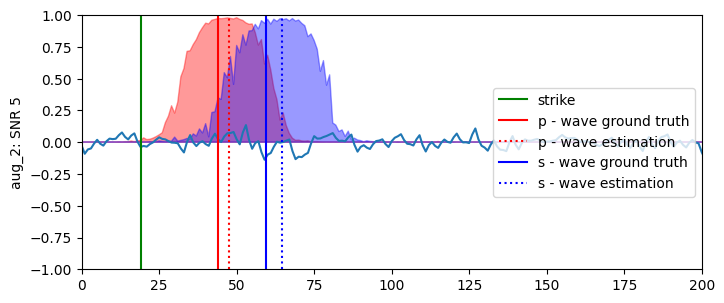

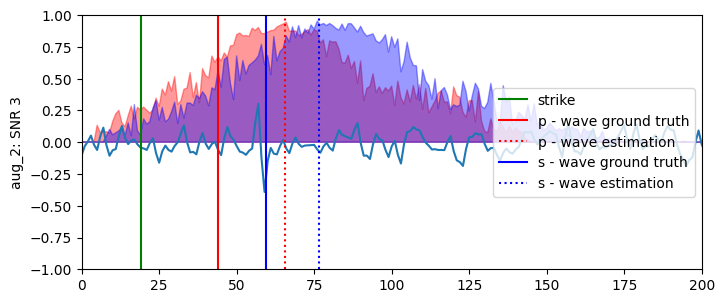

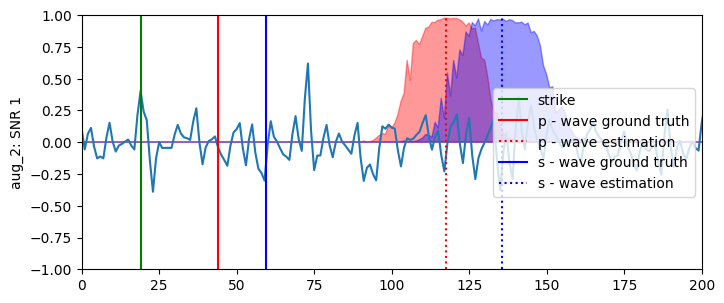

In [64]:
%matplotlib inline

SNR = [1000, 10, 5, 3, 1] # SNR = max(|x|)/(3 sigma)
sigmas =[(s**-1)/3 for s in SNR]

paths = {
        'aug_1': '/content/model_states/c5342_00002_04_18_2023__13_27_19.pt',
        'aug_2': '/content/model_states/c5342_00006_04_18_2023__18_29_14.pt',
         }

for aug in paths.keys():
    for i, s in enumerate(tqdm(sigmas)):
        params = BaseConfig(val_noise_sigma=s)
        net = ArrNetwork(train_h5_path, test_h5_path, params) 
        net.set_weights(paths[aug])

        X, Y = next(iter(net.test_dl))
        x, y = X[42], Y[42]
        y_hat = net(x.unsqueeze(0)).squeeze(0).detach().cpu()

        fig, ax = plot_ch('sta0', 'Z', x, y, y_hat)
        ax.set_ylabel(f'{aug}: SNR {SNR[i]}')

## –ú–æ–¥–µ–ª—å –¥–ª—è –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è –¥–æ –∏—Å—Ç–æ—á–Ω–∏–∫–∞. 
* –ù–∞ —Å–∞–º–æ–º –¥–µ–ª–µ —Å–∞–º–æ–µ –∏–Ω—Ç–µ—Ä–µ—Å–Ω–æ–µ —É–∂–µ –ø—Ä–æ–∏–∑–æ—à–ª–æ –ø—Ä–∏ –ø–æ–∏—Å–∫–µ –≤—Å—Ç—É–ø–ª–µ–Ω–∏–π, –∑–∞–¥–∞—á–∞ –≤—ã—á–∏—Å–ª–µ–Ω–∏—è —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è/–∫–æ–æ—Ä–¥–∏–Ω–∞—Ç –ø–æ –∏–º–µ—é—â–µ–π—Å—è —Ä–∞–∑–º–µ—Ç–∫–µ –≤—Å—Ç—É–ø–ª–µ–Ω–∏–π –æ—Å–æ–±–æ–π —Å–ª–æ–∂–Ω–æ—Å—Ç–∏ –Ω–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è–µ—Ç (–≤ —Ç–æ–π –ø–æ—Å—Ç–∞–Ω–æ–≤–∫–µ, —á—Ç–æ –±—ã–ª–∞ –ø—Ä–∏ –ø–µ—Ä–≤–æ–Ω–∞—á–∞–ª—å–Ω–æ–º –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏–∏). –°–ª–µ–¥—É—é—â–∞—è –º–æ–¥–µ–ª—å –Ω—É–∂–Ω–∞ –≥–ª–∞–≤–Ω—ã–º –æ–±—Ä–∞–∑–æ–º –¥–ª—è —Ç–æ–≥–æ, —á—Ç–æ–±—ã –ø–æ–ª—É—á–∏—Ç—å –ø–æ–Ω—è—Ç–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏ –∫–∞—á–µ—Å—Ç–≤–∞ –ø—Ä–µ–¥—ã–¥—É—â–µ–π –º–æ–¥–µ–ª–∏ - –ø–æ–≥—Ä–µ—à–Ω–æ—Å—Ç—å –≤ –º–µ—Ç—Ä–∞—Ö.
* –ù–∞ –≤—Ö–æ–¥ –º–æ–¥–µ–ª–∏ –ø–æ–¥–∞—ë—Ç—Å—è –≤—Ä–µ–º–µ–Ω–∞ –ø—Ä–∏—Ö–æ–¥–∞ —Ñ–∞–∑, –ø–æ–ª—É—á–µ–Ω–Ω—ã–µ –∏–∑ –æ—Å–Ω–æ–≤–Ω–æ–π –º–æ–¥–µ–ª–∏, –Ω–∞ –≤—ã—Ö–æ–¥–µ –ø–æ–ª—É—á–∞–µ—Ç—Å—è –º–∞—Å—Å–∏–≤ —Å —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è–º–∏ –æ—Ç –∏—Å—Ç–æ—á–Ω–∏–∫–∞ —Å–∏–≥–Ω–∞–ª–∞ –¥–æ –∫–∞–∂–¥–æ–π —Å—Ç–∞–Ω—Ü–∏–∏. –ù–∞ —Å–∞–º–æ–º –¥–µ–ª–µ –≤—Å—ë, —á—Ç–æ —Ç—Ä–µ–±—É–µ—Ç—Å—è –æ—Ç –º–æ–¥–µ–ª–∏ - –ø–æ–Ω—è—Ç—å, —á—Ç–æ –∏—Å–∫–æ–º–æ–π —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ –ø—Ä–æ–ø–æ—Ä—Ü–∏–æ–Ω–∞–ª—å–Ω–æ —Ä–∞–∑–Ω–∏—Ü–µ –≤—Ä–µ–º—ë–Ω –ø—Ä–∏—Ö–æ–¥–∞ —Ñ–∞–∑. –í –±—É–¥—É—â–µ–º —ç—Ç—É –º–æ–¥–µ–ª—å –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –±—É–¥–µ—Ç –∑–∞–º–µ–Ω–∏—Ç—å –Ω–∞ –º–æ–¥–µ–ª—å —Å –¥–µ—Ç–µ–∫—Ü–∏–µ–π –æ—Ç–¥–µ–ª—å–Ω—ã—Ö —Å–∏–≥–Ω–∞–ª–æ–≤.

In [ ]:
class SourceToTargetDist(nn.Module):
    '''
    arrivals -> source to target distances
    input: (batch, sta, self.phases, self.rec_len) for 2 phases
    output: (batch, sta, float:dist)
    '''
    def __init__(self, rec_len, phases=2, scale=1000, sampl_rate=100):
        super().__init__()
        self.rec_len = rec_len
        self.phases = phases
        self.scale = scale # to make it more stable
        self.sampl_rate = sampl_rate
        self.timeline = 1 + torch.arange(self.rec_len, device=device)/self.sampl_rate # to help it to figure out the meaning of x
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(self.phases*self.rec_len, self.phases*self.rec_len)
        self.fc2 = nn.Linear(self.phases*self.rec_len, 1)

    def forward(self, x):
        sh_x = x.shape
        x = x.view(-1, self.rec_len)
        x = x*x*(x+self.timeline) # mask
        x = x.view(-1, self.phases, self.rec_len).flatten(-2,-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = x.unflatten(0, (sh_x[0], sh_x[1])).squeeze(-1)
        return  x * self.scale

### –§—É–Ω–∫—Ü–∏–∏ –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏ –≤—ã—á–∏—Å–ª–µ–Ω–∏—è —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è –æ—Ç –∏—Å—Ç–æ—á–Ω–∏–∫–∞ –¥–æ –≥—Ä—É–ø–ø—ã —Å—Ç–∞–Ω—Ü–∏–π
–ü—Ä–∏ –æ–±—É—á–µ–Ω–∏–∏ –≤ –º–æ–¥–µ–ª—å –¥–ª—è –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è —Å –∑–∞–¥–∞–Ω–Ω–æ–π –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é –ø–æ–¥–∞—é—Ç—Å—è –≤—ã—Ö–æ–¥—ã –º–æ–¥–µ–ª–∏ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –≤—Å—Ç—É–ø–ª–µ–Ω–∏–π —Ñ–∞–∑, –ª–∏–±–æ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏–µ –≤–µ–∫—Ç–æ—Ä—ã –∏–∑ —Ç–∞—Ä–≥–µ—Ç–∞. –≠—Ç–æ –¥–æ–ª–∂–Ω–æ –ø–æ–º–æ—á—å –ª—É—á—à–µ –æ–±—É—á–∏—Ç—å –º–æ–¥–µ–ª—å. 

In [ ]:
def train_one_epoch(dist_model, arr_model, train_dl, test_dl):
    loaders = {'train': train_dl, 'val': test_dl}
    model_modes = {'train': dist_model.train, 'val': dist_model.eval}
    losses = {'train': [], 'val': []}
    for mode in ['train', 'val']:
        model_modes[mode]() # model to train() or eval()
        for X, y_list_of_dicts in tqdm(loaders[mode]):
            y = torch.stack([yy['source_to_target_dist'].to(device) for yy in y_list_of_dicts]) # target is a dict with all staf
            X = X.to(device)

            if mode == 'train' and coin_flip(p=0.0):
                # ground true arrivals
                arr = torch.stack([yy['oh_arrivals'].to(device) for yy in y_list_of_dicts]) 
            else:
                # arrivals from model
                arr = arr_model(X) # arrivals

            y_hat = dist_model(arr) # distances
            l = loss(y_hat, y)
            if mode == 'train':
                optimizer.zero_grad()
                l.backward()
                optimizer.step()

        losses[mode] = torch.sqrt(l).item() # squre root of loss == sigma (m)
        
    return losses

def train_dist_model(dist_model, arr_model, train_dl, test_dl):
    metrics = {'loss':{'train': [], 'val': []},
               'epoch': []} 
    
    dist_model.to(device)
    arr_model.requires_grad_(False)
    arr_model.to(device)
    arr_model.eval()

    for epoch in tqdm(range(epochs)):
        losses = train_one_epoch(dist_model, arr_model, train_dl, test_dl)
        metrics['epoch'].append(epoch)
        metrics['loss']['train'].append(losses['train'])
        metrics['loss']['val'].append(losses['val'])
        if epoch % 1 == 0:
            print(f"Epoch {epoch}:: train loss: {metrics['loss']['train'][-1]:.04f}, val loss: {metrics['loss']['val'][-1]:.04f}")

    return metrics

def eval_dist_model(dist_model, arr_model, test_dl, use_arr_model=True):
    arr_model.requires_grad_(False)
    arr_model.to(device)
    arr_model.eval()

    dist_model.requires_grad_(False)
    dist_model.to(device)
    dist_model.eval()

    for X, y_list_of_dicts in tqdm(test_dl):
        y = torch.stack([yy['source_to_target_dist'].to(device) for yy in y_list_of_dicts]) # target is a dict with all staf
        X = X.to(device)
        if use_arr_model:
            # arrivals from model
            arr = arr_model(X)
        else:
            # ground true arrivals
            arr = torch.stack([yy['oh_arrivals'].to(device) for yy in y_list_of_dicts]) 
            

        y_hat = dist_model(arr) # distances
        l = loss(y_hat, y)

    return torch.sqrt(l).item()

def coin_flip(p=0.5, base=1000):
    i = torch.randint(0, base, (1,)).item()
    return i < p * base


### –°–æ–∑–¥–∞–Ω–∏–µ —ç–∫–∑–µ–º–ø–ª—è—Ä–æ–≤ –º–æ–¥–µ–ª–µ–π

In [ ]:
# arrivals
arr_model = Arrivals(chanels=3, rec_len=400, one_tr_attn_nlayer=1, sta_attn_nlayer=1, J=3, Q=4)

# loading state
pt_path = 'model_states/Aug_1_e3_03_01_state_dict_03_23_2023__17_36_28.pt'
arr_model.load_state_dict(torch.load(pt_path, map_location=torch.device(device)))

# distances
dist_model = SourceToTargetDist(rec_len=400, sampl_rate = dataset.sampl_rate)

### –û–±—É—á–µ–Ω–∏–µ, –≤–∞–ª–∏–¥–∞—Ü–∏—è

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0:: train loss: 207.9795, val loss: 232.0903


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:: train loss: 212.6505, val loss: 211.8570


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2:: train loss: 174.7943, val loss: 201.7388


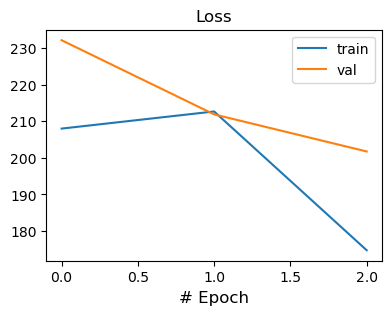

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

train_h5_path = '100k_train.hdf5'
test_h5_path = '1k_val.hdf5'

transforms = stack_transforms([WtFilter(cl=[-1]), Normalizer(), ToTensor(), ToOneHot()])

train = SynthSeism(h5_path = train_h5_path, transforms=transforms)
test = SynthSeism(h5_path = test_h5_path, transforms=transforms)

# this is for testing
# train = torch.utils.data.Subset(train, torch.randperm(2000).tolist())

train_dl = DataLoader(dataset=train,
                      batch_size=100,
                      shuffle=True,
                      collate_fn=dataset.collate_fn, 
                      )

test_dl = DataLoader(dataset=test,
                      batch_size=len(test),
                      shuffle=False,
                      collate_fn=dataset.collate_fn, 
                      )

# loss
loss =  nn.MSELoss(reduction = 'mean')

# optimizer
epochs = 3
lr = 0.0001 
optimizer = torch.optim.Adam(dist_model.parameters(), lr=lr)

metrics = train_dist_model(dist_model, arr_model, train_dl, test_dl)
plot_metrics(metrics)

In [ ]:
#saving path
# !mkdir -p /content/model_states/
pt_path = 'model_states/'+'distance_model_state_dict_'+ datetime.now().strftime("%m_%d_%Y__%H_%M_%S") +'.pt'
torch.save(dist_model.state_dict(), pt_path)

# copy it to gdrive
# !mkdir -p /gdrive/MyDrive/seismo_datasets/model_states/ && cp {pt_path} /gdrive/MyDrive/seismo_datasets/model_states/

## –ü—Ä–æ–≤–µ—Ä–∫–∞ –º–æ–¥–µ–ª–∏ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è –¥–æ –∏—Å—Ç–æ—á–Ω–∏–∫–∞ –Ω–∞ —É—Å—Ç–æ–π—á–∏–≤–æ—Å—Ç—å –∫ —à—É–º—É

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

SNR 1000 <> Loss 252.98924255371094


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 100 <> Loss 291.7685546875


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 30 <> Loss 267.5528869628906


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 10 <> Loss 319.03912353515625


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 5 <> Loss 384.6946716308594


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 3 <> Loss 482.7597351074219


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 2 <> Loss 586.9061279296875


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 1 <> Loss 774.888427734375


Text(0.5, 0, 'SNR')

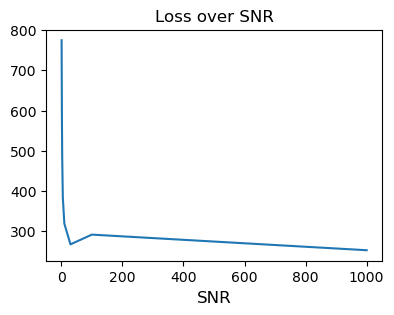

In [ ]:
%matplotlib inline
test_h5_path = '1k_val.hdf5'

loss =  nn.MSELoss(reduction = 'mean')

arr_model = Arrivals(chanels=3, rec_len=400, one_tr_attn_nlayer=1, sta_attn_nlayer=1, J=3, Q=4)
arr_pt_path = 'model_states/Aug_1_e3_03_01_state_dict_03_23_2023__17_36_28.pt'
arr_model.load_state_dict(torch.load(arr_pt_path, map_location=torch.device(device)))

dist_model = SourceToTargetDist(rec_len=400, sampl_rate=100)
dist_pt_path = 'model_states/distance_model_state_dict_03_23_2023__23_01_10.pt'
dist_model.load_state_dict(torch.load(dist_pt_path, map_location=torch.device(device)))

SNR = [1e6, 100, 30, 10, 5, 3, 2, 1] # SNR = max(|x|)/(3 sigma)

sigmas = [(s**-1)/3 for s in SNR]

losses = []

for i, s in enumerate(tqdm(sigmas)):
    
    transforms = stack_transforms([WtFilter(cl=[-1]), Normalizer(), ToTensor(), ToOneHot(), AddNoize(s)])
    
    test = SynthSeism(h5_path = test_h5_path, transforms=transforms)
    
    test_dl = DataLoader(dataset=test,
                      batch_size=len(test),
                      shuffle=False,
                      collate_fn=dataset.collate_fn, 
                      )

    l= eval_dist_model(dist_model, arr_model, test_dl, use_arr_model=True)
    losses.append(l) # sqrt for meters
    print(f"SNR {SNR[i]} <> Loss {l}")

fig, ax = plt.subplots(figsize=(4.33, 3))
ax.plot(SNR, losses, label='STD error (m)')
ax.set_title('Loss over SNR', loc='center', fontsize=12)
ax.set_xlabel('SNR', fontsize=12)

## –î–∞–ª—å—à–µ –≤—Å—è–∫–∏–µ —Ä–∞–±–æ—á–∏–µ –º–æ–º–µ–Ω—Ç—ã, —Å–≤—è–∑—ã–Ω–Ω—ã–µ —Å –æ—Ç–ª–∞–¥–∫–æ–π. –í —Ä–∞–±–æ—Ç–µ –ø—Ä–æ–≥—Ä–∞–º–º—ã –Ω–µ –∏—Å–ø–æ–ª—å–∑—É—é—Ç—Å—è.

torch.Size([10, 5, 3, 16, 50])


Text(0.5, 1.0, 'Time-Frequency spectrogram of signal')

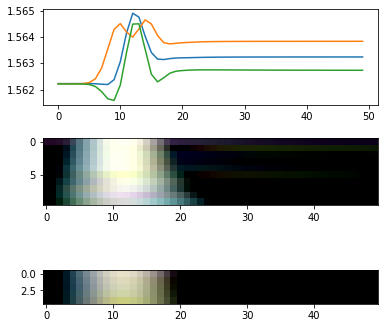

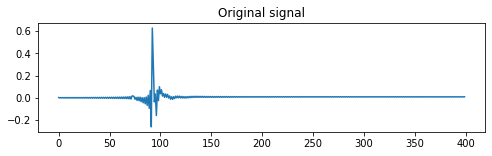

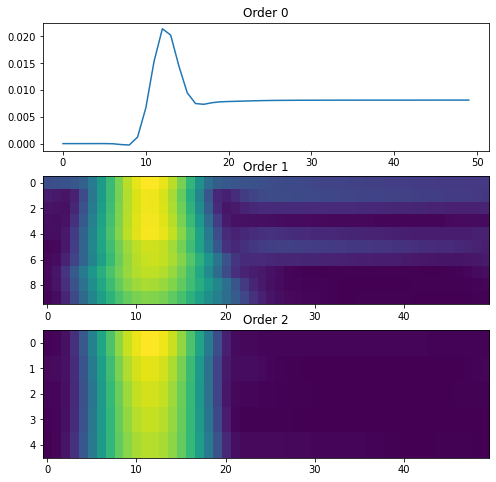

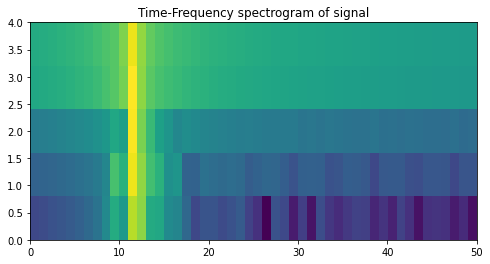

In [ ]:
sc = LogScat(J=3, N=X.shape[-1], Q=4)

Sx, meta = sc(X)
print(Sx.shape)

img = Sx[0][0]
mean, std = torch.mean(img), torch.std(img)
img  = ((img-mean)/std +0.5)/2
# m = nn.Sigmoid()
# img= m(img)
fig, ax = plt.subplots(3,1, figsize=(6, 6))
ax[0].plot(img.permute(1, 2, 0).numpy()[0])
ax[1].imshow(img.permute(1, 2, 0).numpy()[1:11])
ax[2].imshow(img.permute(1, 2, 0).numpy()[11:])


order = [np.where(meta['order'] == order) for order in [0,1,2]]
x = X[0][0][0]

# signal
plt.figure(figsize=(8, 2))
plt.plot(x)
plt.title('Original signal')

# 0 order
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(Sx[0][0][0][order[0]][0])
plt.title('Order 0')

# 1-2 order
for ii in [1,2]:
    plt.subplot(3, 1, ii+1)
    plt.imshow(Sx[0][0][0][order[ii]], aspect='auto')
    plt.title(f'Order {ii}')

plt.figure(figsize=(8, 4))
plt.specgram(x, Fs=8, NFFT=8, noverlap=0, detrend='mean')
plt.title("Time-Frequency spectrogram of signal")

In [ ]:
meta
# https://github.com/kymatio/kymatio/blob/main/kymatio/scattering1d/filter_bank.py
# psi(t) = g_{sigma}(t) (e^{i xi t} - kappa)
# central frequency
# 'xi': normalized center frequency, where 0.5 corresponds to Nyquist.
# about meta https://github.com/kymatio/kymatio/blob/main/kymatio/scattering1d/frontend/base_frontend.py

{'order': array([0, 1, 1, 1, 1, 2, 2, 2]), 'xi': array([[    nan,     nan],
        [0.35   ,     nan],
        [0.175  ,     nan],
        [0.0875 ,     nan],
        [0.04375,     nan],
        [0.35   , 0.04375],
        [0.175  , 0.04375],
        [0.0875 , 0.04375]]), 'sigma': array([[       nan,        nan],
        [0.14013095,        nan],
        [0.07006547,        nan],
        [0.03503274,        nan],
        [0.01751637,        nan],
        [0.14013095, 0.01751637],
        [0.07006547, 0.01751637],
        [0.03503274, 0.01751637]]), 'j': array([[nan, nan],
        [ 0., nan],
        [ 0., nan],
        [ 0., nan],
        [ 1., nan],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]]), 'n': array([[nan, nan],
        [ 0., nan],
        [ 1., nan],
        [ 2., nan],
        [ 3., nan],
        [ 0.,  3.],
        [ 1.,  3.],
        [ 2.,  3.]]), 'key': [(),
  (0,),
  (1,),
  (2,),
  (3,),
  (0, 3),
  (1, 3),
  (2, 3)]}

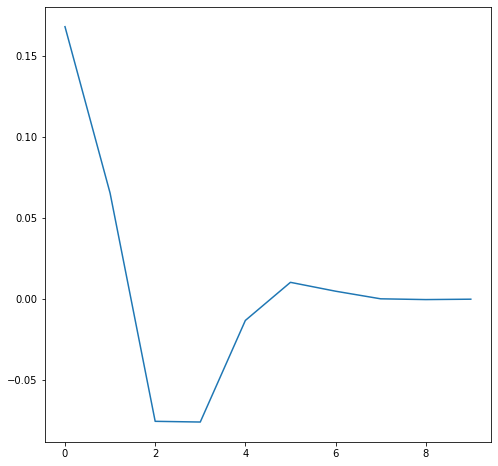

In [ ]:
from kymatio.scattering1d.filter_bank import scattering_filter_factory
from scipy.fft import fft, ifft, fftfreq

# psi(t) = g_{sigma}(t) (e^{i xi t} - kappa)

T=2**12
J=10
Q= (1,1)
phi_f, psi1_f, psi2_f = scattering_filter_factory(T, J, Q, T)

yf = psi1_f[1]['levels'][0]

plt.figure(figsize=(8, 8))
plt.plot(ifft(yf)[0:10])

In [ ]:
psi1_f

[{'levels': [array([ 0.00000000e+00,  7.51697631e-07,  1.50340807e-06, ...,
          -2.25501565e-06, -1.50335645e-06, -7.51684434e-07])],
  'xi': 0.35,
  'sigma': 0.14013094769175247,
  'j': 0},
 {'levels': [array([-5.21180213e-18,  1.50466153e-06,  3.00937422e-06, ...,
          -4.51367769e-06, -3.00916961e-06, -1.50461038e-06])],
  'xi': 0.175,
  'sigma': 0.07006547384587623,
  'j': 0},
 {'levels': [array([-5.21180212e-18,  3.00937421e-06,  6.01895304e-06, ...,
          -9.02689503e-06, -6.01813461e-06, -3.00916961e-06])],
  'xi': 0.0875,
  'sigma': 0.03503273692293812,
  'j': 0},
 {'levels': [array([-5.21180212e-18,  6.01895304e-06,  1.20387246e-05, ...,
          -1.80519488e-05, -1.20354509e-05, -6.01813461e-06])],
  'xi': 0.04375,
  'sigma': 0.01751636846146906,
  'j': 1},
 {'levels': [array([-5.21180212e-18,  1.20387246e-05,  2.40807233e-05, ...,
          -3.60965333e-05, -2.40676284e-05, -1.20354509e-05])],
  'xi': 0.021875,
  'sigma': 0.00875818423073453,
  'j': 2},
 {'le

### Sakhalin dataset operations (not used yet)



In [ ]:
h5_path = '/content/data/SAKH-2014_2021_global_norm.h5'
with h5py.File(h5_path, 'r') as f:
    X, Y = (f['X'][:], f['Y'][:])

trace_no = 0 # event
chnlz= [0, 1, 2] # chanels

fig, ax = plt.subplots(3,1, figsize=(8,6*2))
with h5py.File(h5_path, 'r') as f:
    for ii in chnlz:
        ax[ii].plot(f[f"X"][trace_no][:,ii])
        ax[ii].set_title(f'Label: {f["Y"][trace_no]}') # 0 = p, 1 = s, 2 = noise ?


In [ ]:

def num_to_one_hot(num, size):
    lo_int = torch.floor(num)
    hi_int = torch.ceil(num)
    lo_val = hi_int - num
    hi_val = num - lo_int
    ss = size * torch.ones_like(num)
    sp = torch.sparse_coo_tensor(torch.cat((lo_int, hi_int), dim=-1), torch.cat((lo_val, hi_val), dim=-1), size=ss)
    return sp.to_dense()



x = torch.tensor([[[1.1, 2.5, 3.4], [4.6,2.5,5.2]], [[2.5,7.5,9.7], [2.5, 5,3.8]]])
ssize = 15

def make_my_tricky_oh(x, oh_size):
    # my mind is blowing
    lo_int = torch.floor(x)
    hi_int = torch.ceil(x)
    lo_val = hi_int - x
    hi_val = x - lo_int
  
    xs = x.to_sparse_coo()
    ii = xs.indices()
    ss = xs.size()
    # new indieces
    flo_int = lo_int.view(1,-1)
    lo_ii = torch.cat((ii, flo_int))
    fhi_int = hi_int.view(1,-1)
    hi_ii = torch.cat((ii, fhi_int))
    new_ii = torch.cat((lo_ii, hi_ii), dim=-1)
    # new values
    lo_vv = lo_val.view(-1)
    hi_vv = hi_val.view(-1)
    new_vv = torch.cat((lo_vv, hi_vv), dim=-1)
    # new size
    new_ss = list(ss)
    new_ss.append(oh_size)
    # sparse to dense
    my_new_shiny_sparse_tensor = torch.sparse_coo_tensor(new_ii, new_vv, new_ss)
    my_georgious_oh = my_new_shiny_sparse_tensor.to_dense()
    return my_georgious_oh

make_my_tricky_oh(x, 20)

tensor([[[[0.0000, 0.9000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.6000, 0.4000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.4000, 0.6000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0

old transforms

In [ ]:
def filtering(tr, wt='db2', calcelled_levels = [-1]):
    '''som wavelet filtering, not sure about it yet'''
    coeffs = pywt.wavedec(tr, wt, mode='constant')
    for ii in calcelled_levels:
        coeffs[ii] = np.zeros_like(coeffs[ii])
    tr_hat = pywt.waverec(coeffs, wt)
    
    return tr_hat

def transforms(traces, targets):
    # filtration
    # no cl == no filtering
    traces = filtering(traces, calcelled_levels = [])

    # normalization
    # every event (stack of 5*3 traces) is normalized on max ampl. separately 
    # because of very large span of ampls. (~8 orders of degree).
    # norm goes into targets['params']['signal_max']
    max_abs = np.max(np.abs(traces))
    traces = traces/max_abs
    targets['params'].update({'signal_max': max_abs.item()})

    # to tensors
    traces = torch.tensor(traces, dtype=torch.float)
    targets['arrivals'] = torch.tensor(targets['arrivals'], dtype=torch.float) 
    targets['source_to_target_dist'] = torch.tensor(targets['source_to_target_dist'], dtype=torch.float)

    # arrivals -> one hot tensors
    # this is for future expansion for working with continuous traces.
    # result goes to targets['oh_arrivals']
    s_rate = targets['params']['s_rate'] # 100 Hz
    arr = targets['arrivals'] # seconds
    arr = arr[:,1:] # NO STRIKE INFO, just p and s
    tr_len = traces.shape[-1] # trace len
    arr = torch.floor(arr*s_rate).long() # floor because arrival is the last zero sampl

    # for future me: torch.sparse_coo_tensor is better to be there
    oh_arrivals = F.one_hot(arr, num_classes=tr_len).float()
    targets.update({'oh_arrivals': oh_arrivals})  

    return traces, targets

In [ ]:
# splitting the dataset into the train and test set
torch.manual_seed(1)
set_size = len(dataset)
test_share = 0.01
rand_idxs = torch.randperm(set_size).tolist()

train = torch.utils.data.Subset(dataset, rand_idxs[:-int(test_share*set_size)])
test = torch.utils.data.Subset(dataset, rand_idxs[-int(test_share*set_size):])


In [ ]:
# delete me after testing
@wandb_mixin
def tune_testing(config):
    from time import sleep
    # decoy func just to test
    # config = BaseConfig(**config).__dict__
    drop = config['fc_drop']
    x = 0
    goal = 10
    for epoch in range(100):    
        x += drop + 0.1 * torch.randn(1).item()
        lossy = goal - x
        losses = {'train': lossy, 'val': 0}
         # all config to wandb
        losses.update({'foo':'bar'}) 
        wandb.log(losses) # wandb here

        # wandb first tune report after
        tune.report(**losses)
        sleep(0.1)

In [ ]:
# Plotting ray tuning resulst
fig, ax = plt.subplots(figsize=(4.33, 3))

results_done = (r for r in results if r.metrics_dataframe is not None)
for result in results_done:
    label = f"drop={result.config['fc_drop']:.3f}"
    result.metrics_dataframe.plot("training_iteration", "train", ax=ax, label=label, marker='.')

ax.set_title("Train Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Train Loss")

best_result = results.get_best_result("train", "min")
print(f'Best trial config: {best_result.config}')

# dfs = {result.log_dir: result.metrics_dataframe for result in results}    
# print(f'Best trial final train loss: {best_result.metrics["train"]}')
# print(f'Best trial final val loss: {best_result.metrics["val"]}')

In [ ]:
# if needed
import ray
ray.init()
!ray status

2023-04-12 13:47:40,078	INFO worker.py:1553 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.9.16', ray_version='2.3.1', ray_commit='5f14cee8dfc6d61ec4fd3bc2c440f9944e92b33a', address_info={'node_ip_address': '172.28.0.12', 'raylet_ip_address': '172.28.0.12', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2023-04-12_13-47-37_452084_5814/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2023-04-12_13-47-37_452084_5814/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2023-04-12_13-47-37_452084_5814', 'metrics_export_port': 49574, 'gcs_address': '172.28.0.12:54471', 'address': '172.28.0.12:54471', 'dashboard_agent_listen_port': 52365, 'node_id': '51870491633069be95c4f8cd395f6b15357b43e6773d8377495018c6'})

In [ ]:
%matplotlib inline
pt_path_1 = 'model_states/Aug_2noise_no_spikes_state_dict_03_30_2023__17_58_13.pt' 
pt_path_2 = 'model_states/Aug_1_2xNoise_01_01_Drops_state_dict_03_24_2023__18_11_59.pt' 

SNR = [1e6, 100, 30, 10, 5, 3, 2, 1] # SNR = max(|x|)/(3 sigma)
sigmas =[(s**-1)/3 for s in SNR]

mode = ['aug_1', 'aug_2']
losses = {mode[0]:[], mode[1]:[]}
paths = {mode[0]:pt_path_1, mode[1]:pt_path_2}

for m in mode:
    for i, s in enumerate(tqdm(sigmas)):
        params = BaseConfig(val_noise_sigma=s)
        net = ArrNetwork(train_h5_path, test_h5_path, params) 
        net.set_weights(pt_path)
        l = net.evaluate()
        losses[m].append(l)

        # just for pics
        X, Y = next(iter(net.test_dl))
        x, y = X[42], Y[42]
        y_hat = net(x.unsqueeze(0)).squeeze(0).detach().cpu().numpy()
        print(f"SNR {SNR[i]} <> Loss {l}")

        fig, ax = plt.subplots(figsize=(12,4))
        ax.plot(x[0][0])
        ax.axvline(x=y['arrivals'][0][0]*100, color='g', label = 'strike') # strike moment
        ax.axvline(x=y['arrivals'][0][1]*100, color='r', label = 'p - wave') # p-wave arrival
        ax.fill_between(np.arange(400), y_hat[0][0], color='r', alpha = 0.4)
        ax.axvline(x=y['arrivals'][0][2]*100, color='b', label = 's - wave') # s-wave arrival
        ax.fill_between(np.arange(400), y_hat[0][1], color='b', alpha = 0.4)
        ax.set_ylabel(f'{m}: SNR {SNR[i]}')
        ax.set_xlim(0,200)
        ax.set_ylim(-1,1)


fig, ax = plt.subplots(1,1, figsize=(4.33, 3))
ax.plot(SNR, losses[mode[0]], label=f'{mode[0]} loss')
ax.plot(SNR, losses[mode[1]], label=f'{mode[1]} loss')
ax.set_title('Loss over SNR', loc='center', fontsize=12)
ax.set_xlabel('SNR', fontsize=12)
ax.set_xlim(0,10)
ax.legend()